In [1]:
from visualizations import * 

from matching import Matcher


from matplotlib import pyplot as plt
plt.style.use('ggplot')

from MAG_network import CitationNetwork
import os 
from matplotlib import pyplot as plt
import pandas as pd
import findspark
import MAGspark
import itertools

import sys

import numpy as np
import scipy
from scipy.stats import ks_2samp

sys.path.insert(0,"/home/laal/MAG/CentralityFairness/Evaluations")

ImportError: cannot import name 'plot_group_dist' from partially initialized module 'visualizations' (most likely due to a circular import) (/home/laal/MAG/CentralityFairness/visualizations.py)

In [2]:
mag, spark = MAGspark.get_mag_with_cluster_connection(jobid=44857, memory_per_executor=14000,
                                                      data_folderpath="/home/laal/MAG/DATA/")

['NAME STATE JOBID', 'tweets-shuffled-bilstm-0 PENDING 44859', 'baseline-adam-learning_rate-4 PENDING 44820', 'piano_ppl RUNNING 44860', 'test RUNNING 44861', 'main_job RUNNING 44648', 'sparkcluster RUNNING 44857', 'train-gpu RUNNING 44721', 'baseline-adam-bilstm-learning_rate-1 RUNNING 44816', 'baseline-adam-bilstm-learning_rate-2 RUNNING 44817', 'simple9 RUNNING 44752', 'baseline-adam-bilstm-learning_rate-3 RUNNING 44818', 'baseline-adam-bilstm-learning_rate-0 RUNNING 44815', 'baseline-adam-simplernn-learning_rate-0 RUNNING 44810', 'baseline-adam-learning_rate-3 RUNNING 44809', 'baseline-adam-learning_rate-2 RUNNING 44808', 'baseline-adam-learning_rate-1 RUNNING 44807', 'ant_bullet RUNNING 44387', 'jupyter RUNNING 44845', '']


In [3]:
def compute_ks_test(mag, centrality_df, fos_id, base_filepath="/home/laal/MAG/DATA"):
    
    centrality_df[['AuthorId', 'Gender']].to_csv(base_filepath + "/CentralityAuthors.txt", header=False,index=False, sep="\t")
    
    mag.streams['CentralityAuthors'] = ('CentralityAuthors.txt', ['AuthorId:long', 'Gender:int'])
    
    inter_event = mag.getDataframe('InterEventPublications')
    cent_authors = mag.getDataframe('CentralityAuthors')
    
    query = """
        SELECT iep.AuthorId, ca.Gender, iep.DateDiff 
        FROM InterEventPublications  iep
        INNER JOIN CentralityAuthors ca ON iep.AuthorId = ca.AuthorId
        WHERE FieldOfStudyId = {} AND PrevPaperId != CurrentPaperId
    """.format(fos_id)
    
    
    datediffs = mag.query_sql(query).toPandas()
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']
    
    ks_test = ks_2samp(women_interevent.values, men_interevent.values)
    
    return datediffs, ks_test


def plot_inter_event_cdf(datediffs, ks_test, field_name, filepath=None):
    labelsize = 20
    women_interevent = datediffs.query("Gender == 0")['DateDiff']
    men_interevent = datediffs.query("Gender == 1")['DateDiff']
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

    women_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', 
                          linewidth=3, color="#6fc9f2", label="Women")

    men_interevent.hist(cumulative=True, density=1, bins=2000, histtype='step', linewidth=3, 
                        label="Men", color="#bd8aff")

    plt.xlim(-100, 2500)
    plt.ylim(0.0, 1.05)

    title = r"$\bf{" +  field_name.replace(" ", "\ ")  + "}$" +  \
    ":\nCDF: Number of days between consequtive publishing dates"
    title += "\n KS statistic: {0:.3f}".format(ks_test.statistic) + ", p-value: {0:.3f}".format(ks_test.pvalue)
    
    plt.title(title, color='#363534')
    plt.xlabel('Number of days', color='#363534', fontsize=labelsize)
    plt.ylabel('Cumulative probability', color='#363534', fontsize=labelsize)
    
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    
    plt.legend(loc="right")
    
    if filepath is not None:
        plt.savefig(filepath)
        
    plt.show()
    
    

def plot_centrality_correlations(field_name, matched_data, filename=None):

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8), sharex=False, sharey=False)
    axs = list(axs.flatten())
    
    labelsize = 12
    idx = 0
    
    matched_data['MAG Rank'] = 1 / matched_data['Rank'] 
    
    CENTRALITIES = ['PageRank', 'PageRank05', 'InDegreeStrength', 'MAG Rank']
    
    for cent1, cent2 in itertools.combinations(CENTRALITIES, r=2):
    
        corr = scipy.stats.pearsonr(matched_data[cent1], matched_data[cent2])
        axs[idx].scatter(x=matched_data[cent1], y=matched_data[cent2], color="#ff8c00", alpha=0.3)
        axs[idx].set_title("{} vs. {}".format( cent1, cent2 ) + "\n Corr = {0:.3f}, p-value=".format(corr[0]) + "{0:.3f}".format(corr[1]),
                          color='#363534')
        axs[idx].set_ylabel(cent2, fontsize=labelsize, color='#363534')
        axs[idx].set_xlabel(cent1, fontsize=labelsize, color='#363534')
        
        axs[idx].tick_params(axis='y', labelsize=labelsize)
        axs[idx].tick_params(axis='x', labelsize=labelsize, rotation=45)
        
        idx += 1


    plt.suptitle('Centrality correlations for matched population: ' + r"$\bf{" +  field_name.replace(" ", "\ ")  + "}$", 
                 fontsize=16, color='#363534')
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    plt.show()

--------------------------------STARTING VIZ ON ECONOMICS-----------------------------


gender counts before query:

1    304369
0    111367
Name: Gender, dtype: int64
Men with more than 1 paper:  (144398, 12)
Women with more than 1 paper:  (51698, 12)
Number of men before removing NaN-affiliation bin: 144398
Number of women before removing NaN-affiliation bin: 51698
Number of men after removing NaN-affiliation bin: 115100
Number of women after removing NaN-affiliation bin: 42355


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 102285.0
Matched data median: 104163.5


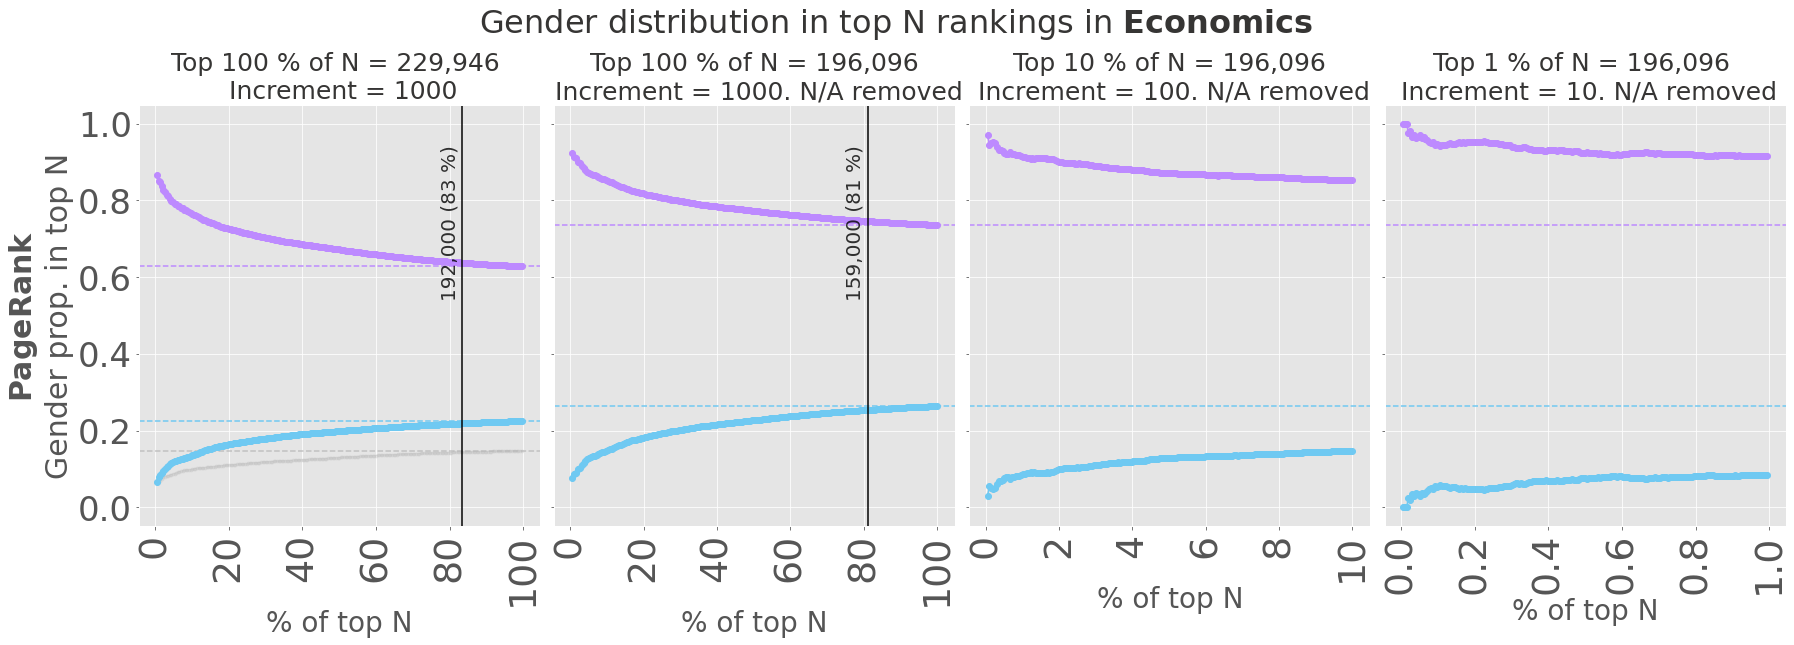

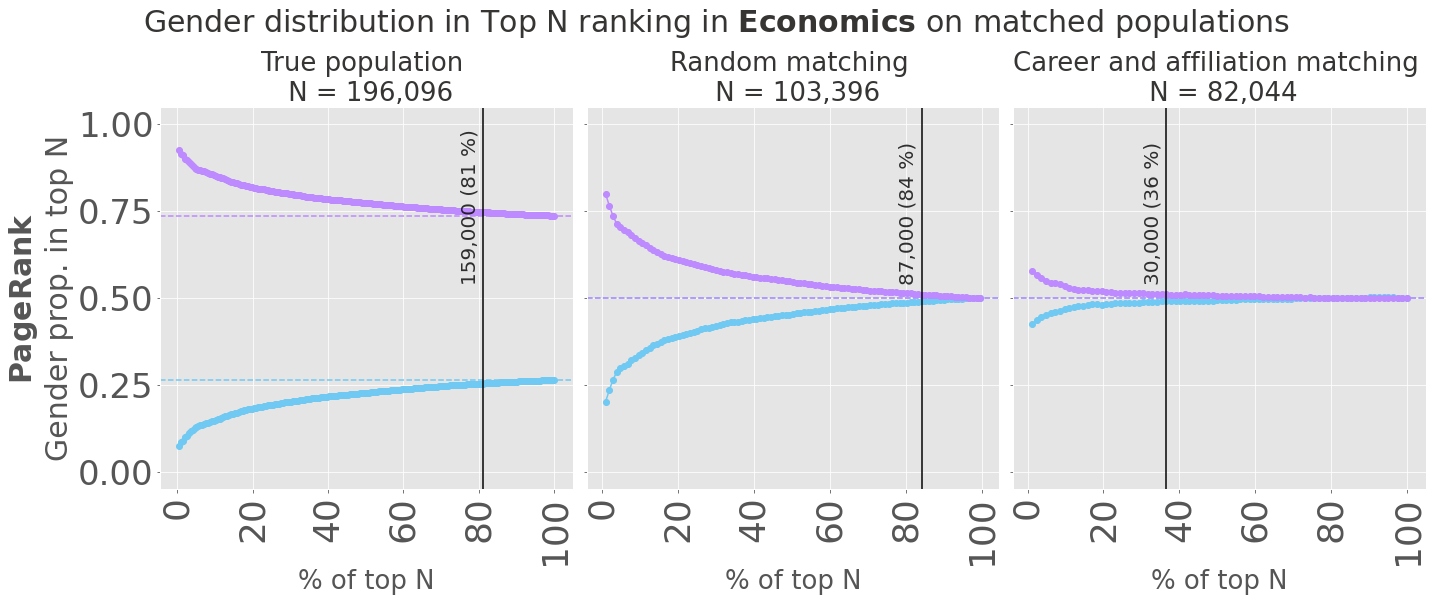

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 101908.5
Matched data median: 102711.0


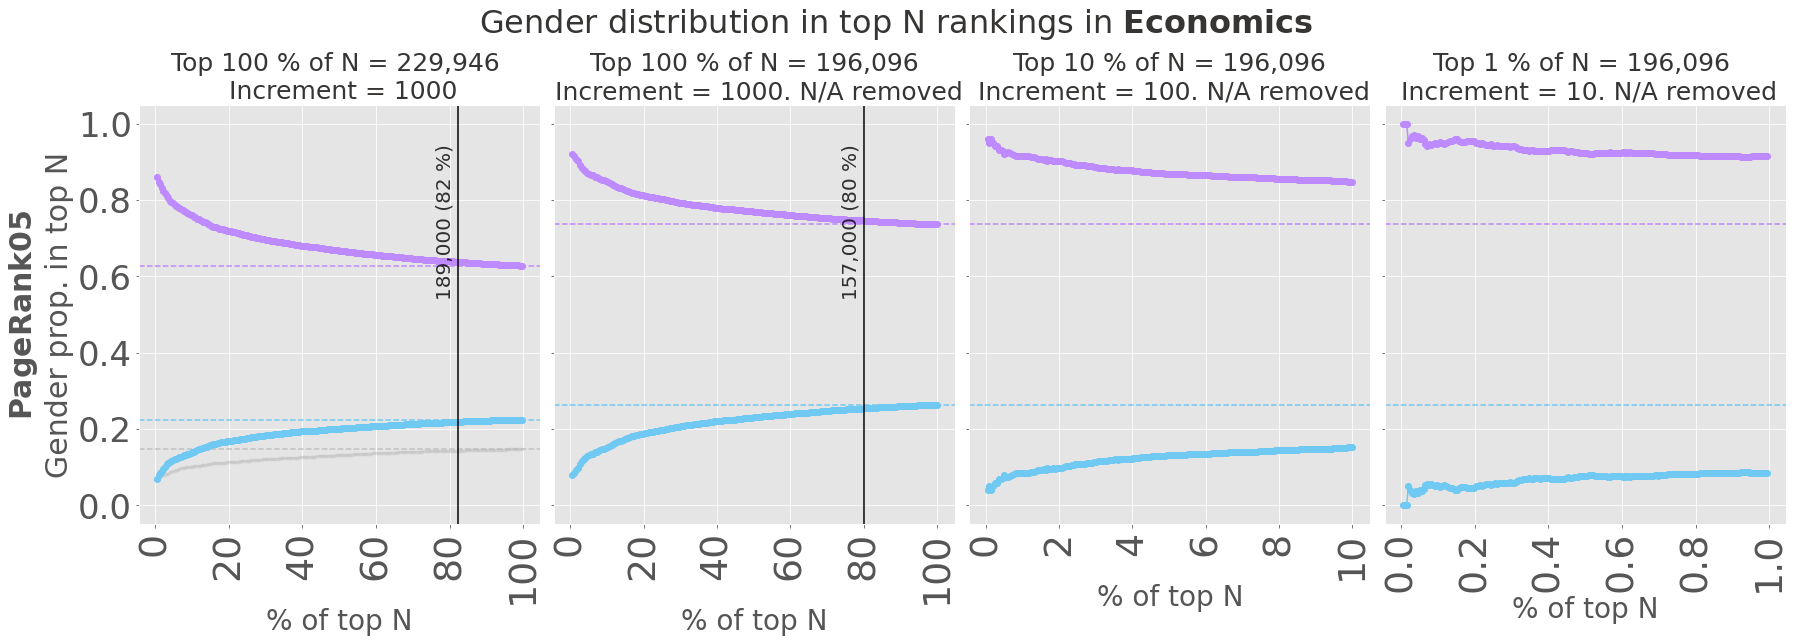

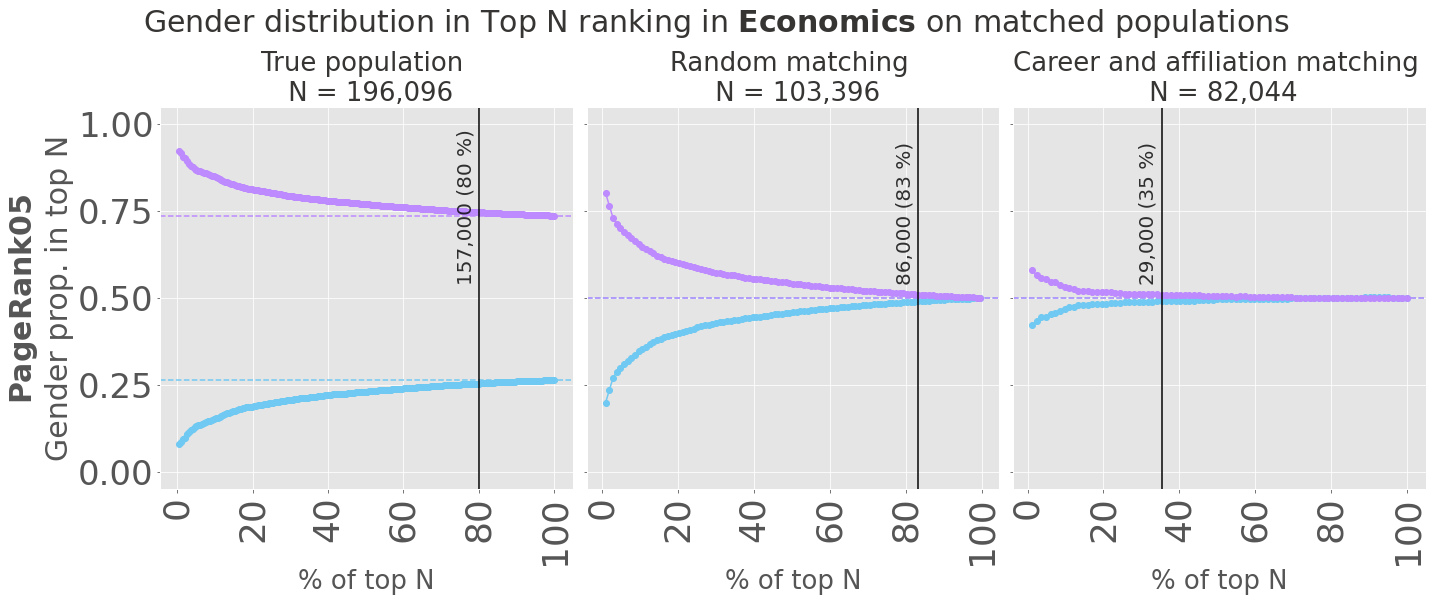

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 101441.5
Matched data median: 98729.5


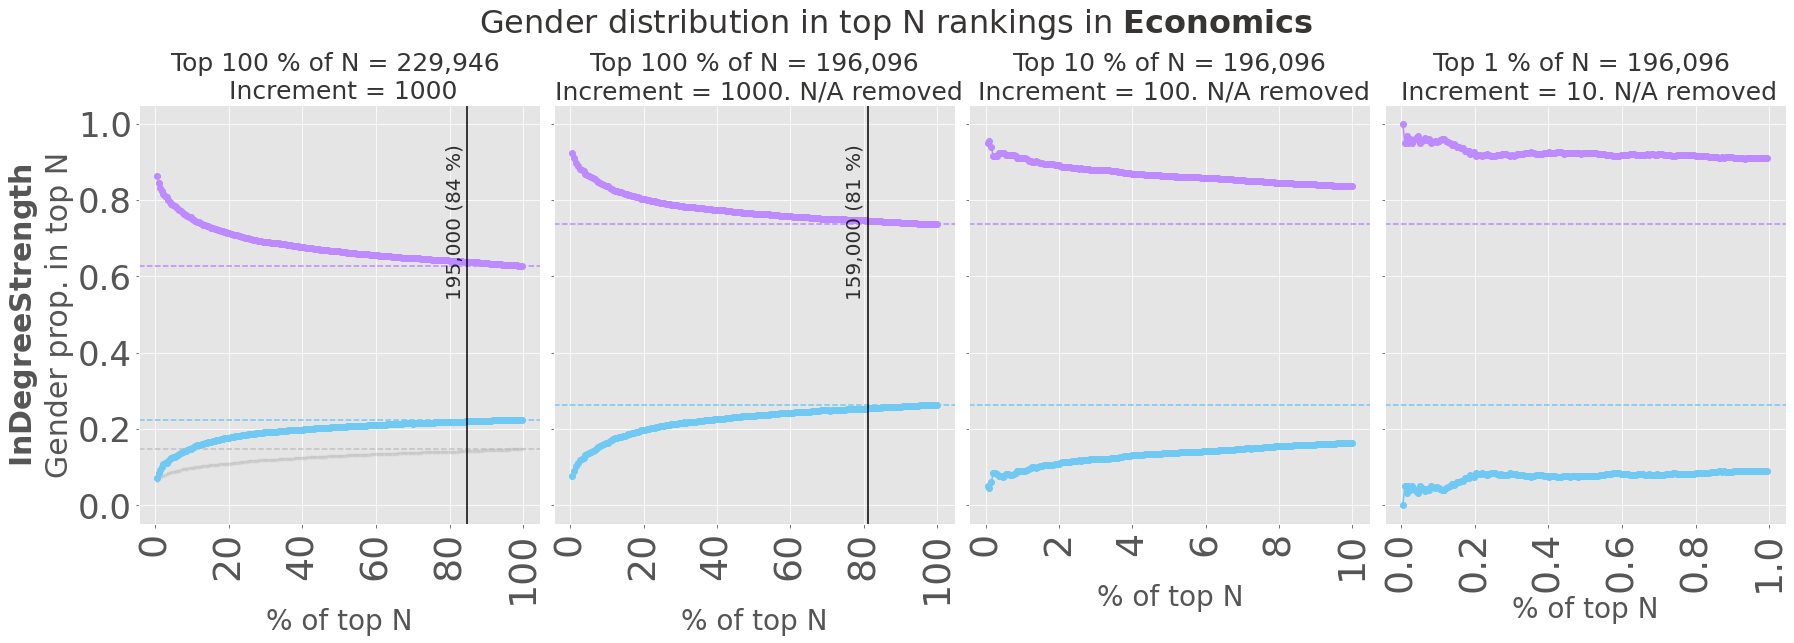

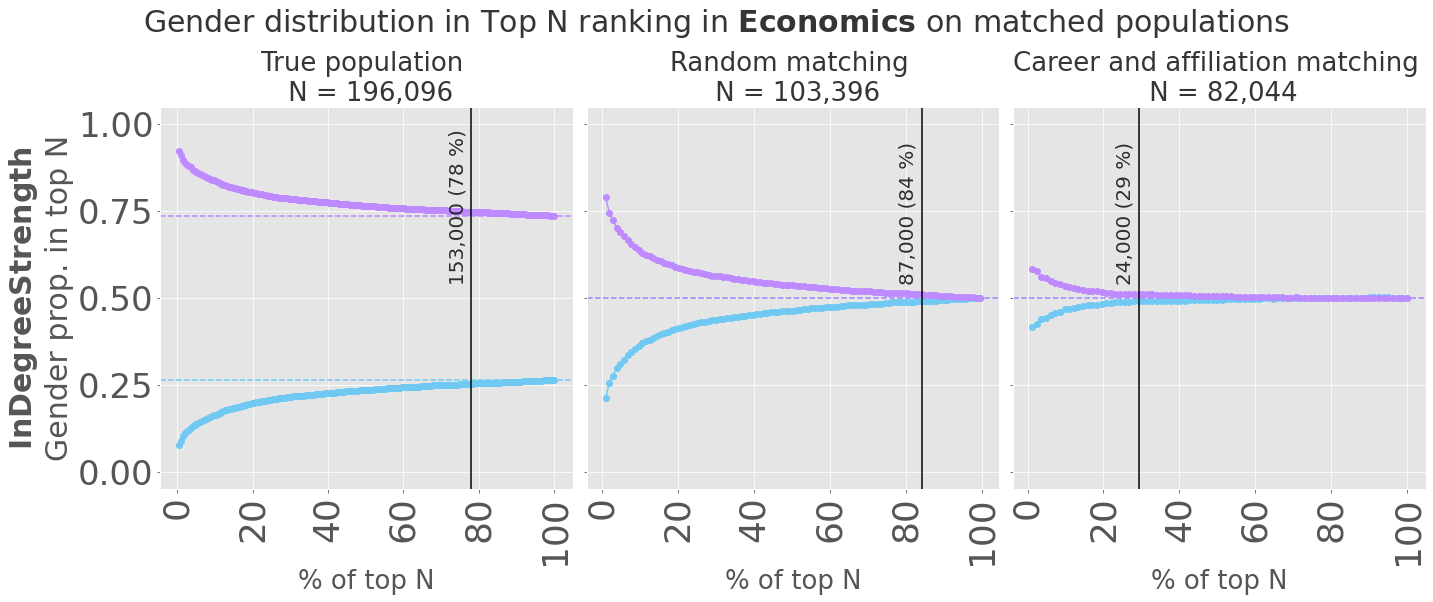

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 98047.5
Random data median: 100529.5
Matched data median: 94236.0


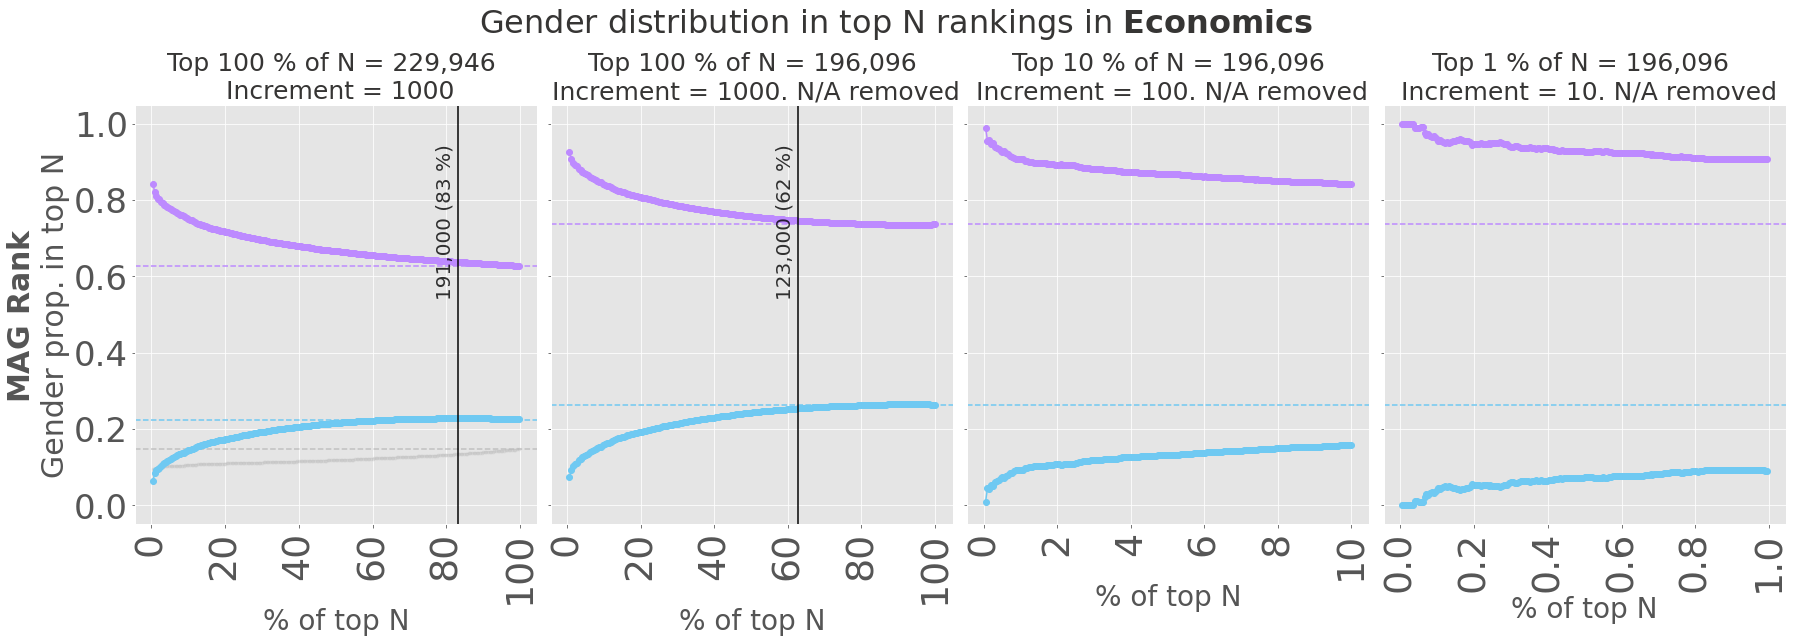

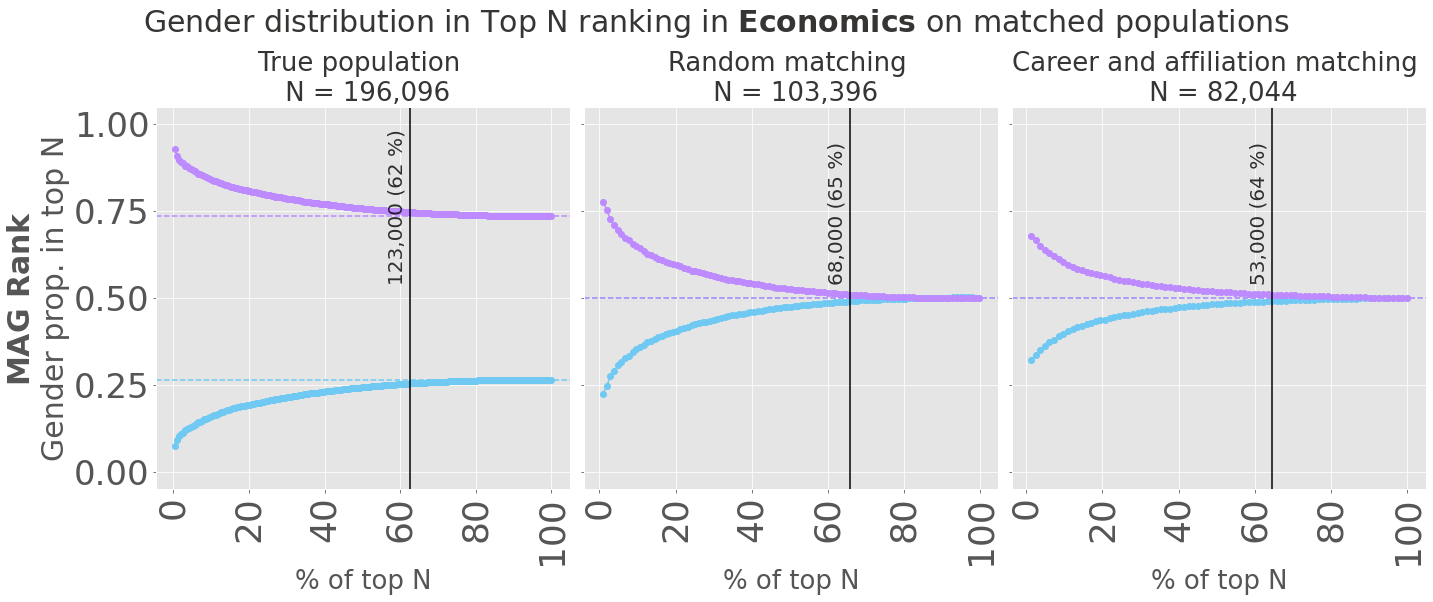

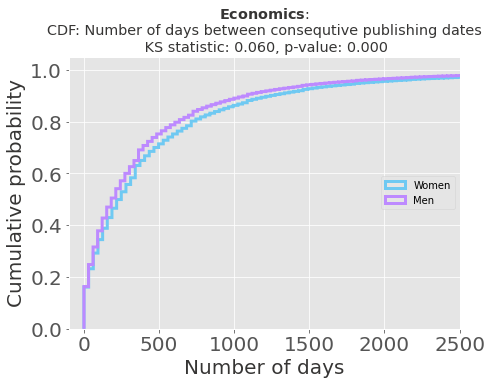

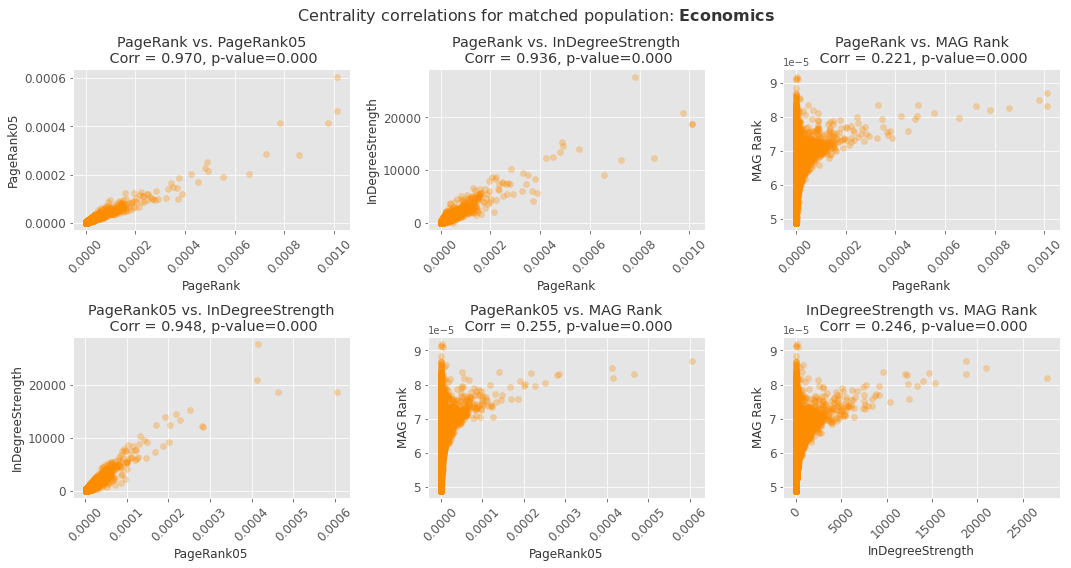

--------------------------------STARTING VIZ ON PSYCHOLOGY-----------------------------


gender counts before query:

0    814668
1    808992
Name: Gender, dtype: int64
Men with more than 1 paper:  (382847, 12)
Women with more than 1 paper:  (380440, 12)
Number of men before removing NaN-affiliation bin: 382847
Number of women before removing NaN-affiliation bin: 380440
Number of men after removing NaN-affiliation bin: 306191
Number of women after removing NaN-affiliation bin: 316480


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381711.5
Matched data median: 374091.0


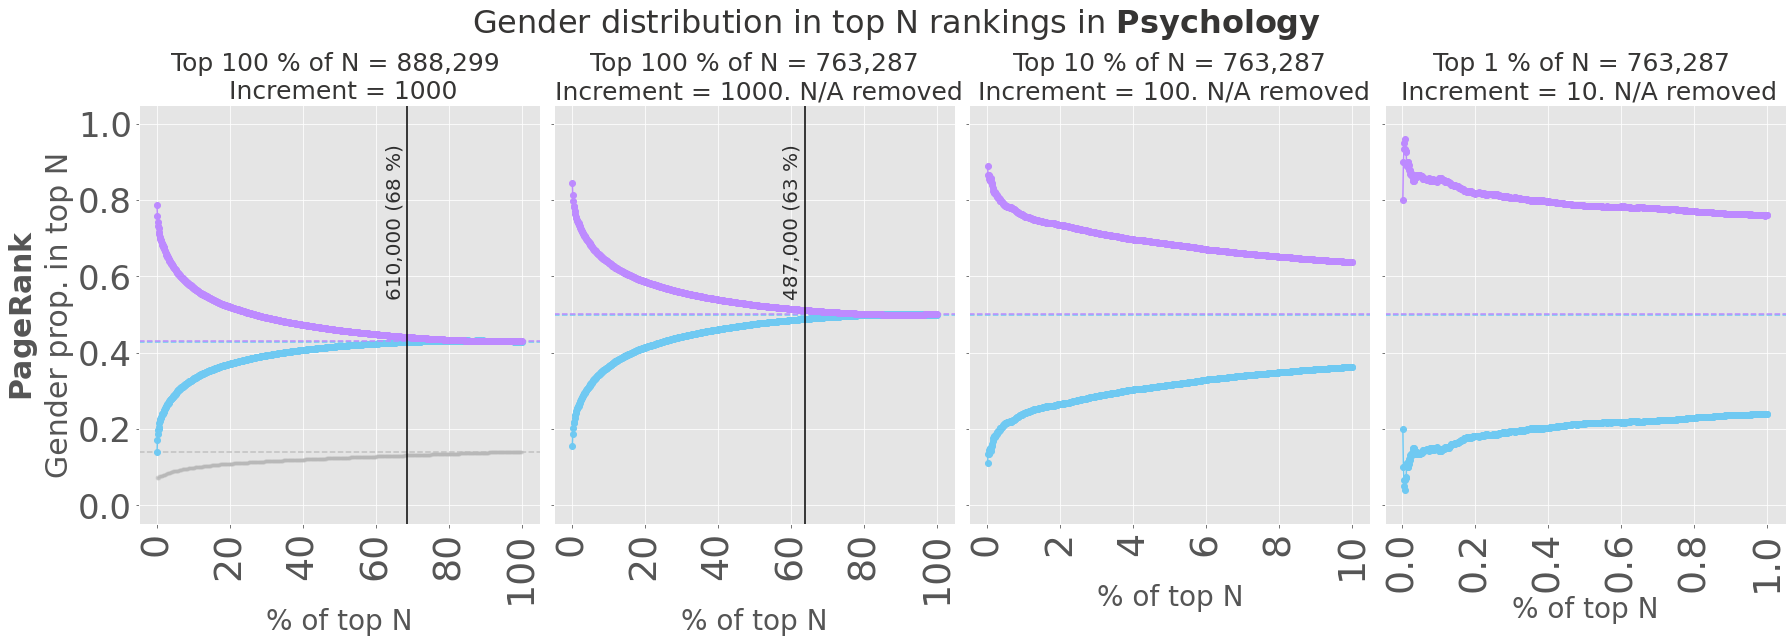

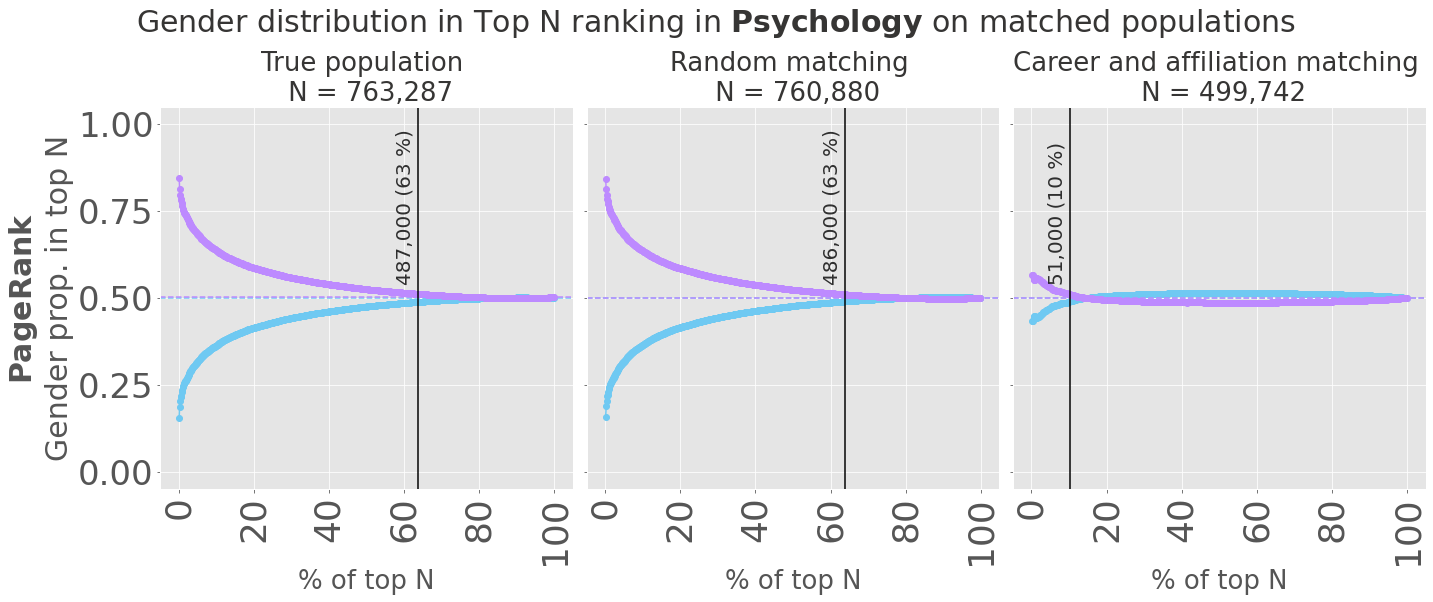

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381694.5
Matched data median: 370926.0


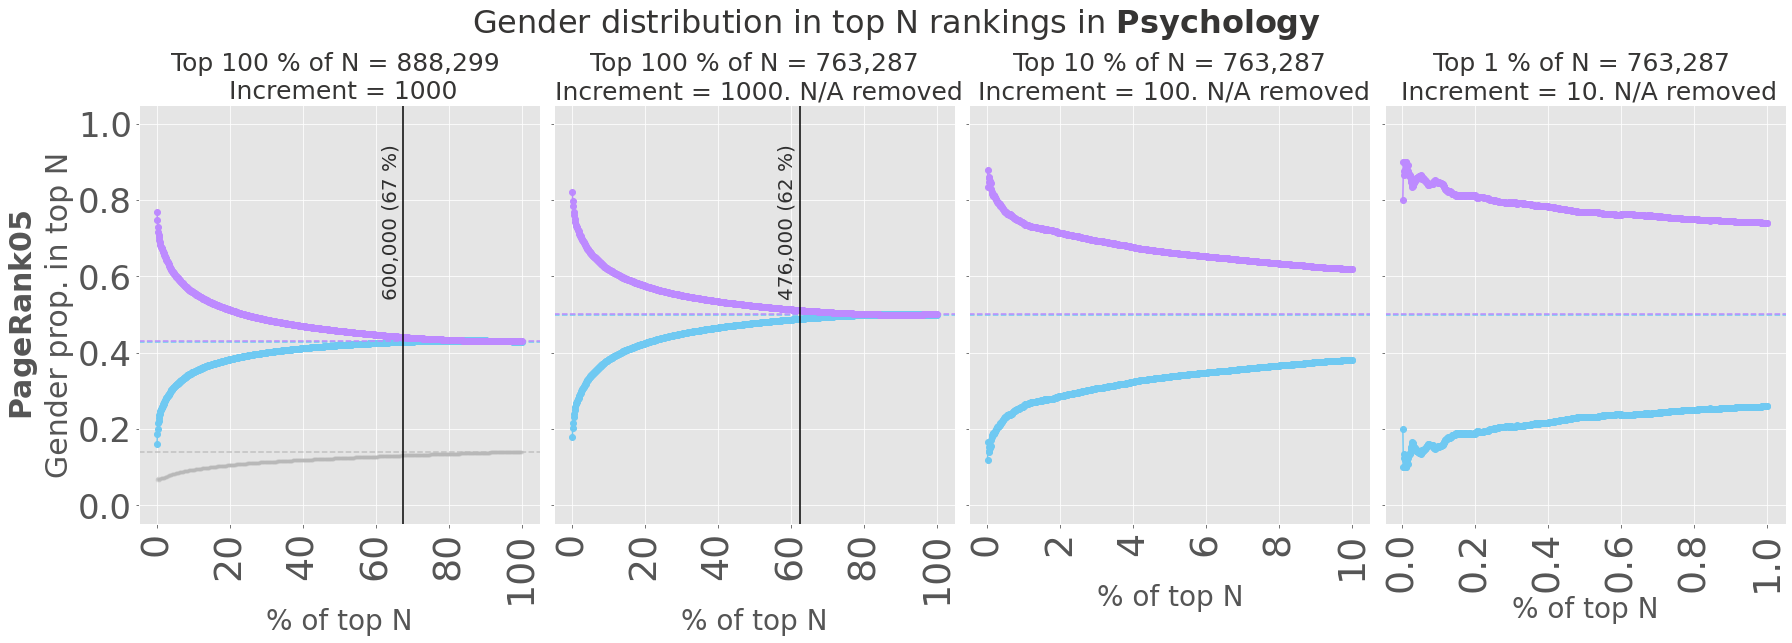

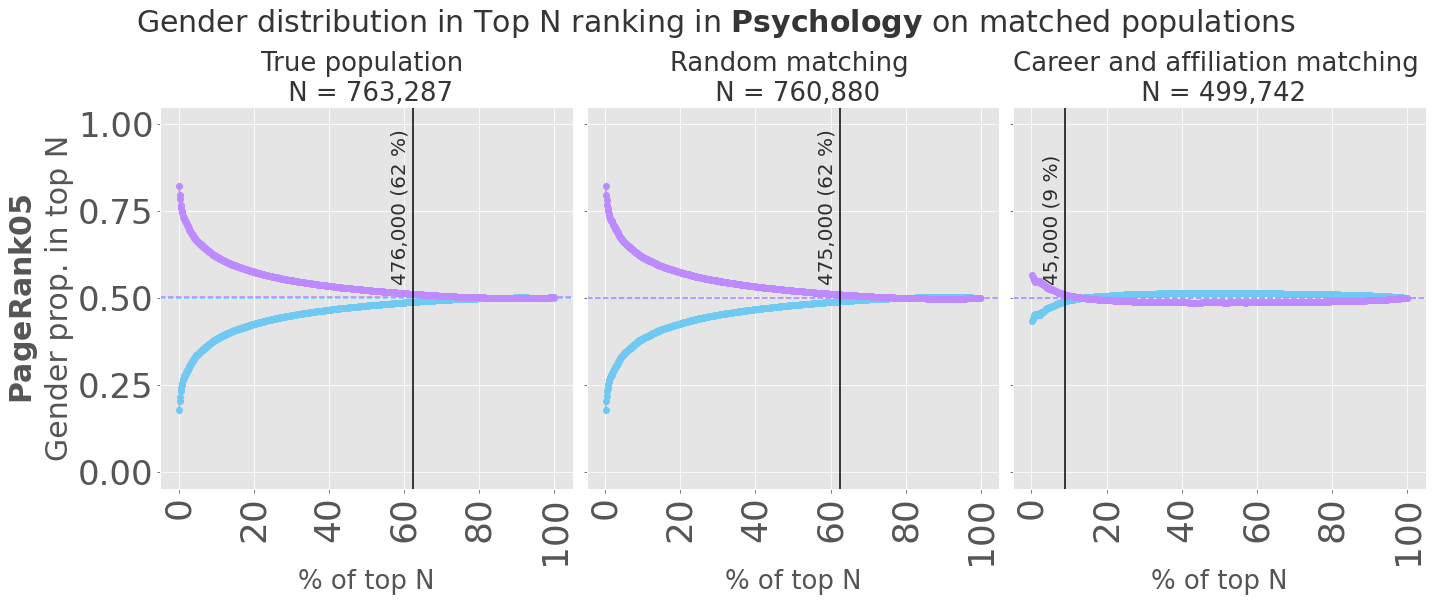

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381641.5
Matched data median: 360969.0


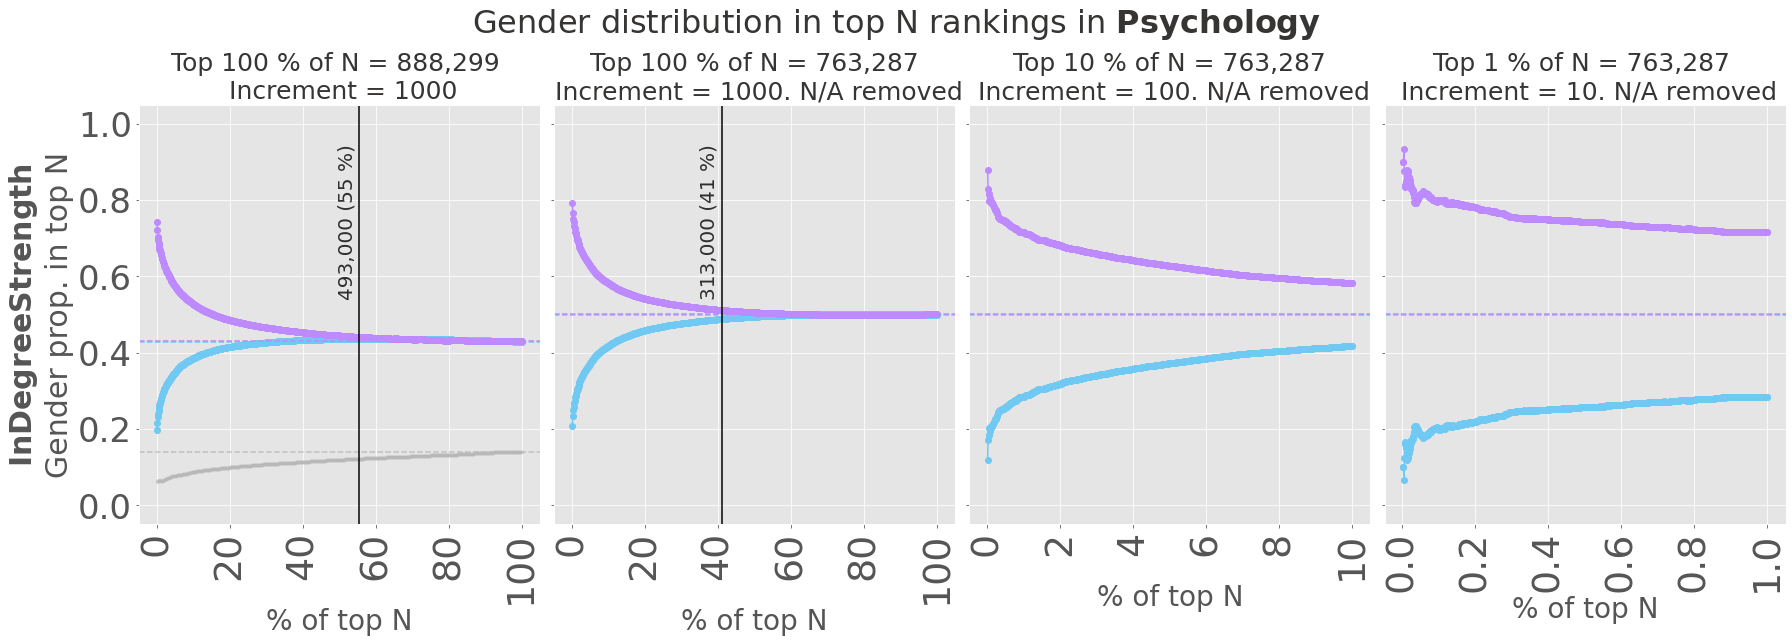

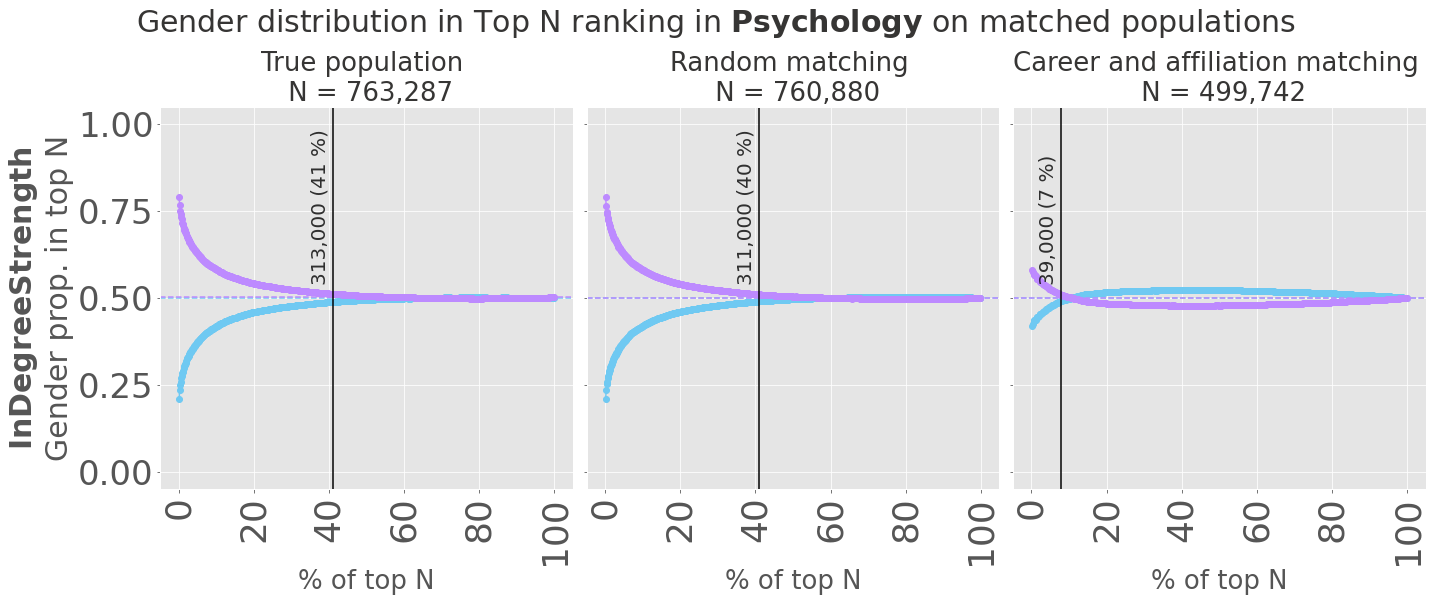

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 381643.0
Random data median: 381825.5
Matched data median: 339054.5


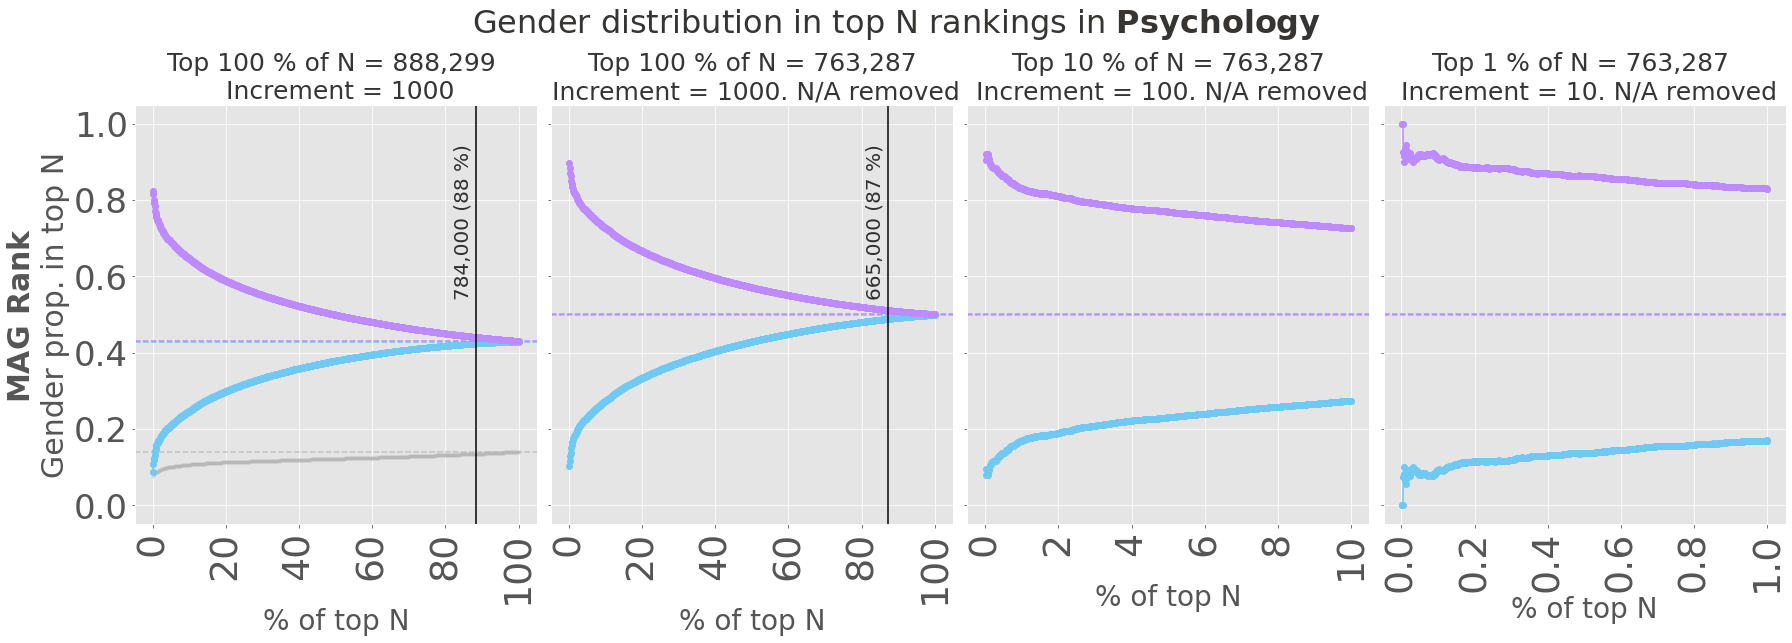

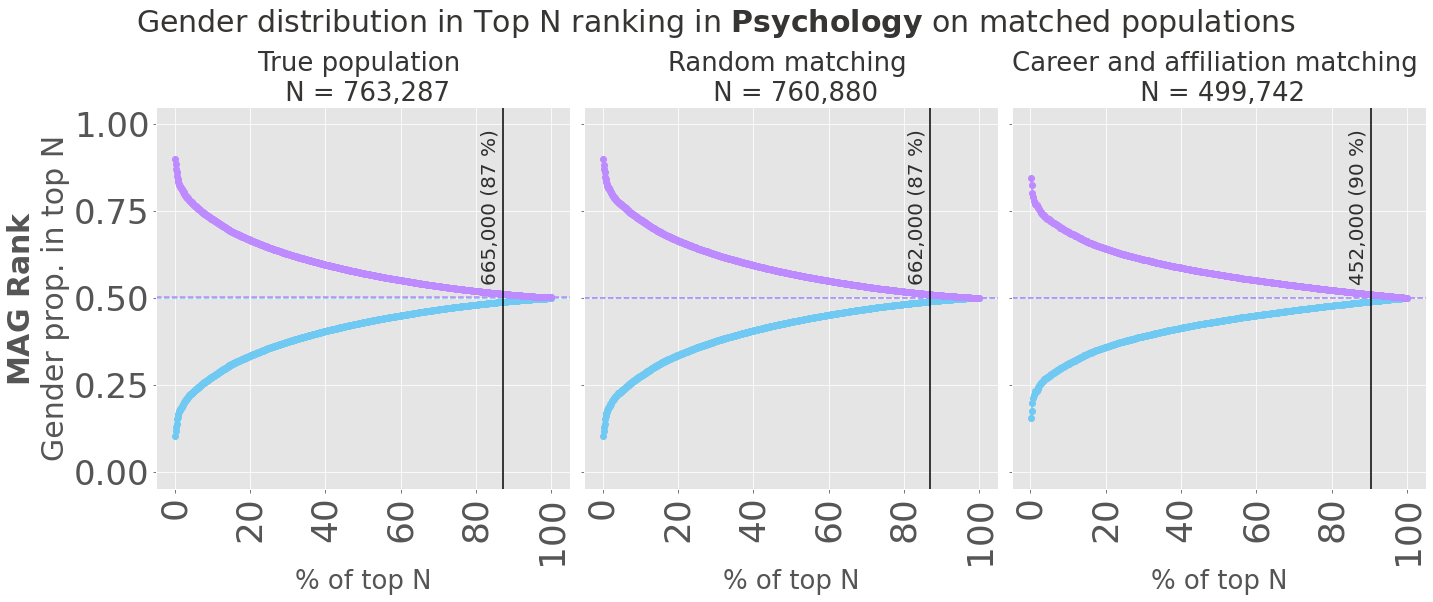

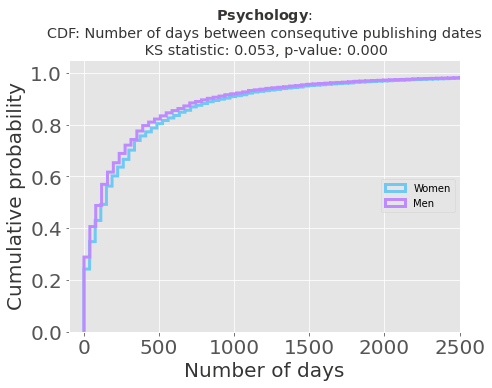

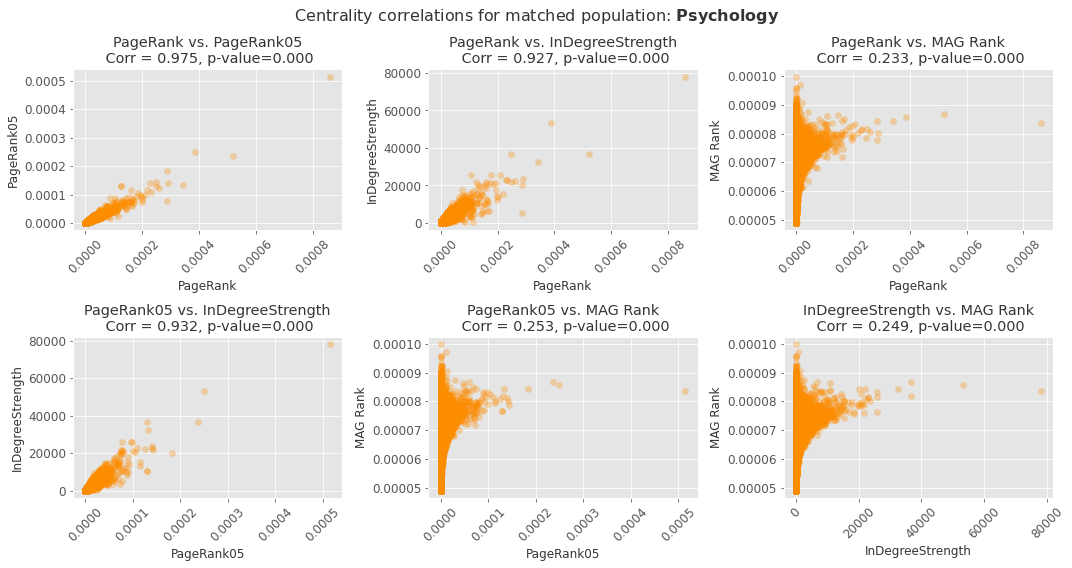

--------------------------------STARTING VIZ ON MATHEMATICS-----------------------------


gender counts before query:

1    753573
0    215664
Name: Gender, dtype: int64
Men with more than 1 paper:  (372092, 12)
Women with more than 1 paper:  (96644, 12)
Number of men before removing NaN-affiliation bin: 372092
Number of women before removing NaN-affiliation bin: 96644
Number of men after removing NaN-affiliation bin: 310905
Number of women after removing NaN-affiliation bin: 82769


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 247372.5
Matched data median: 259051.5


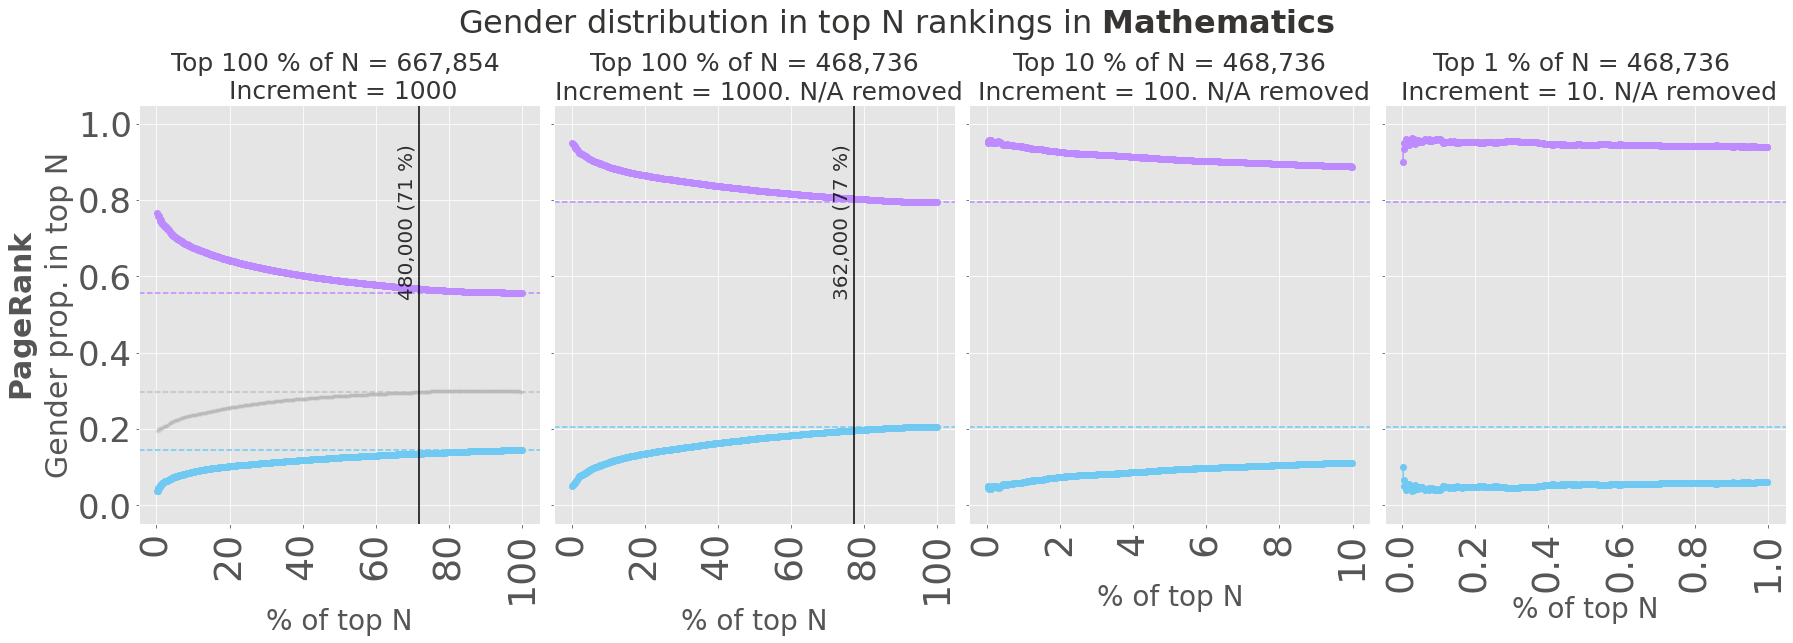

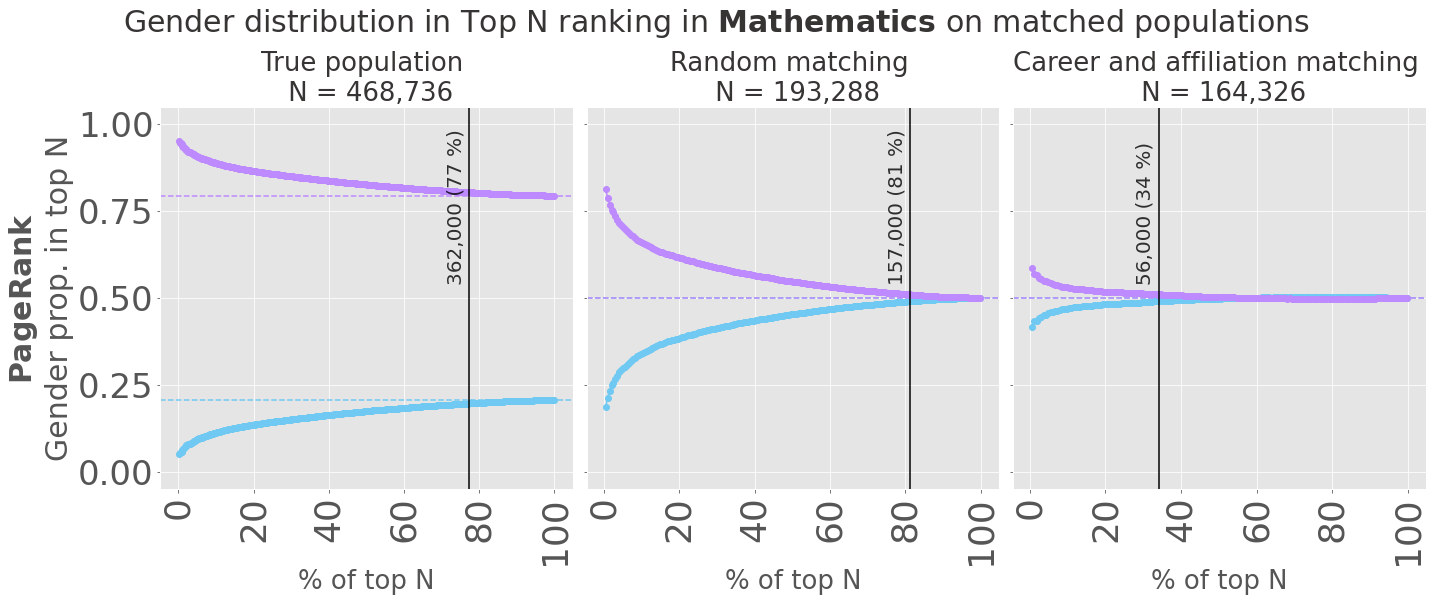

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 247016.5
Matched data median: 257837.0


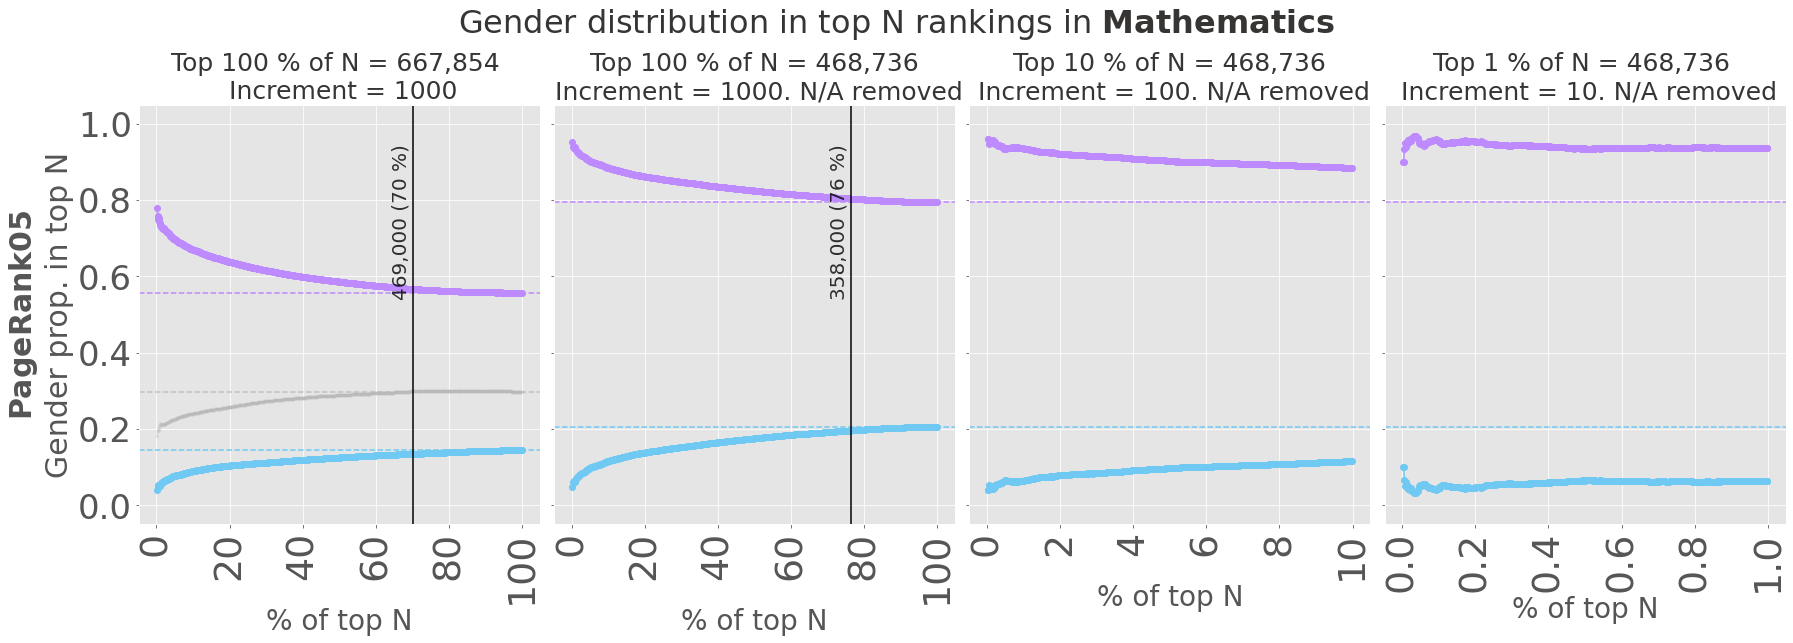

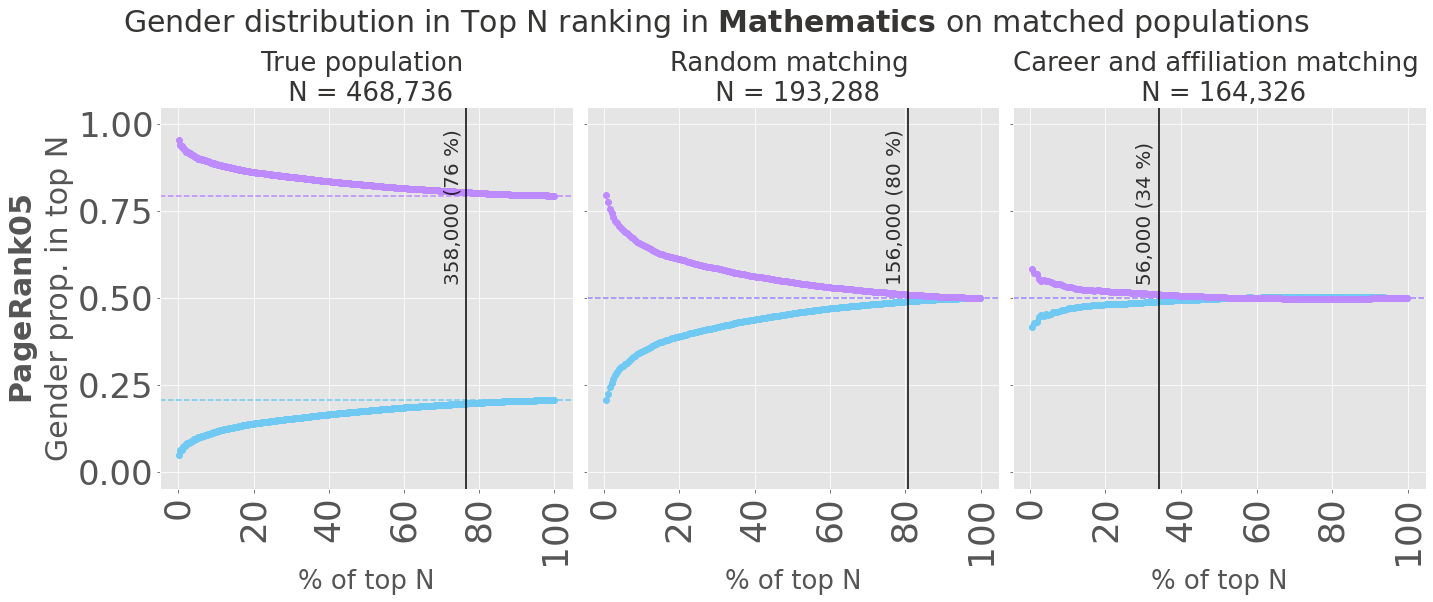

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 243317.5
Matched data median: 247133.0


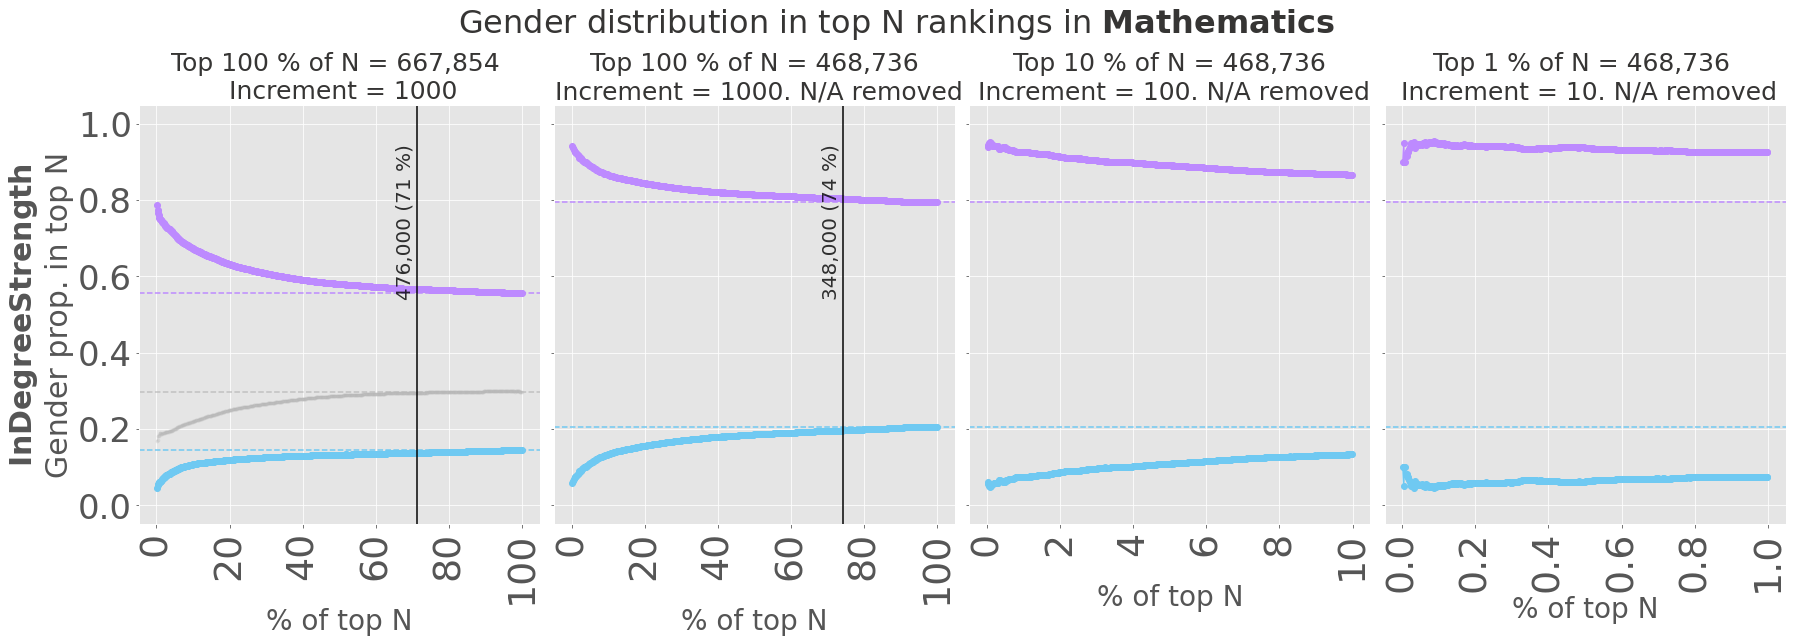

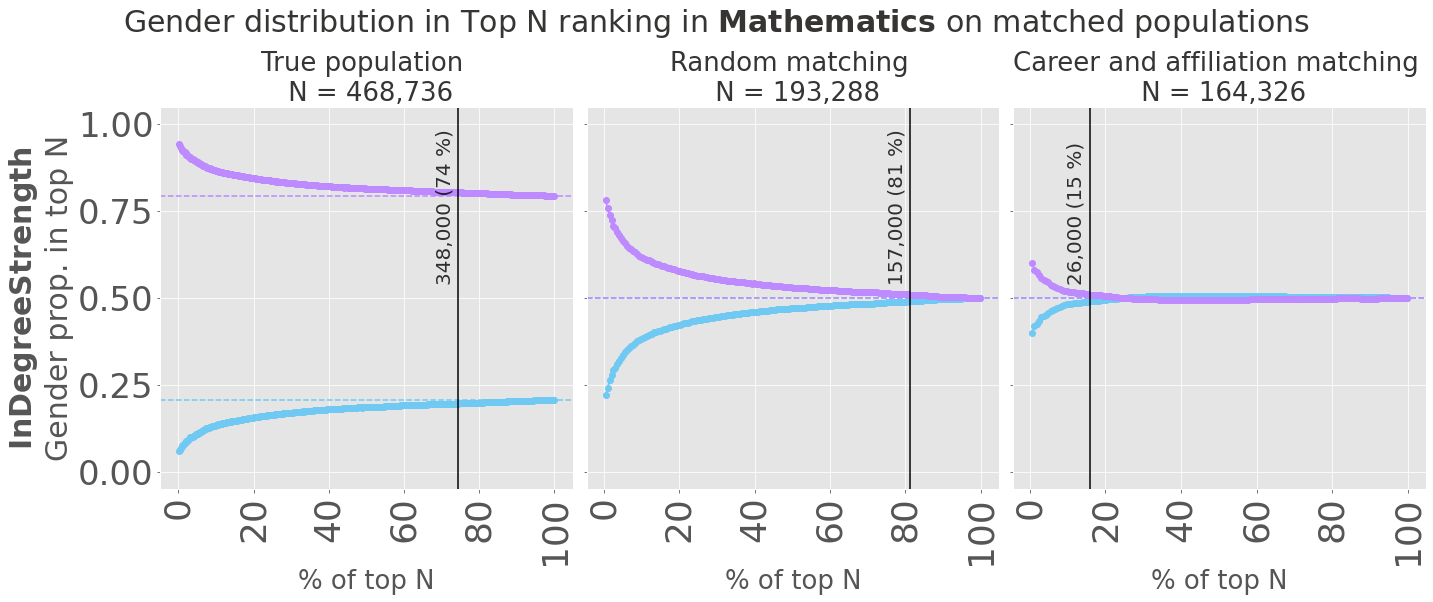

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 234367.5
Random data median: 250622.0
Matched data median: 247397.5


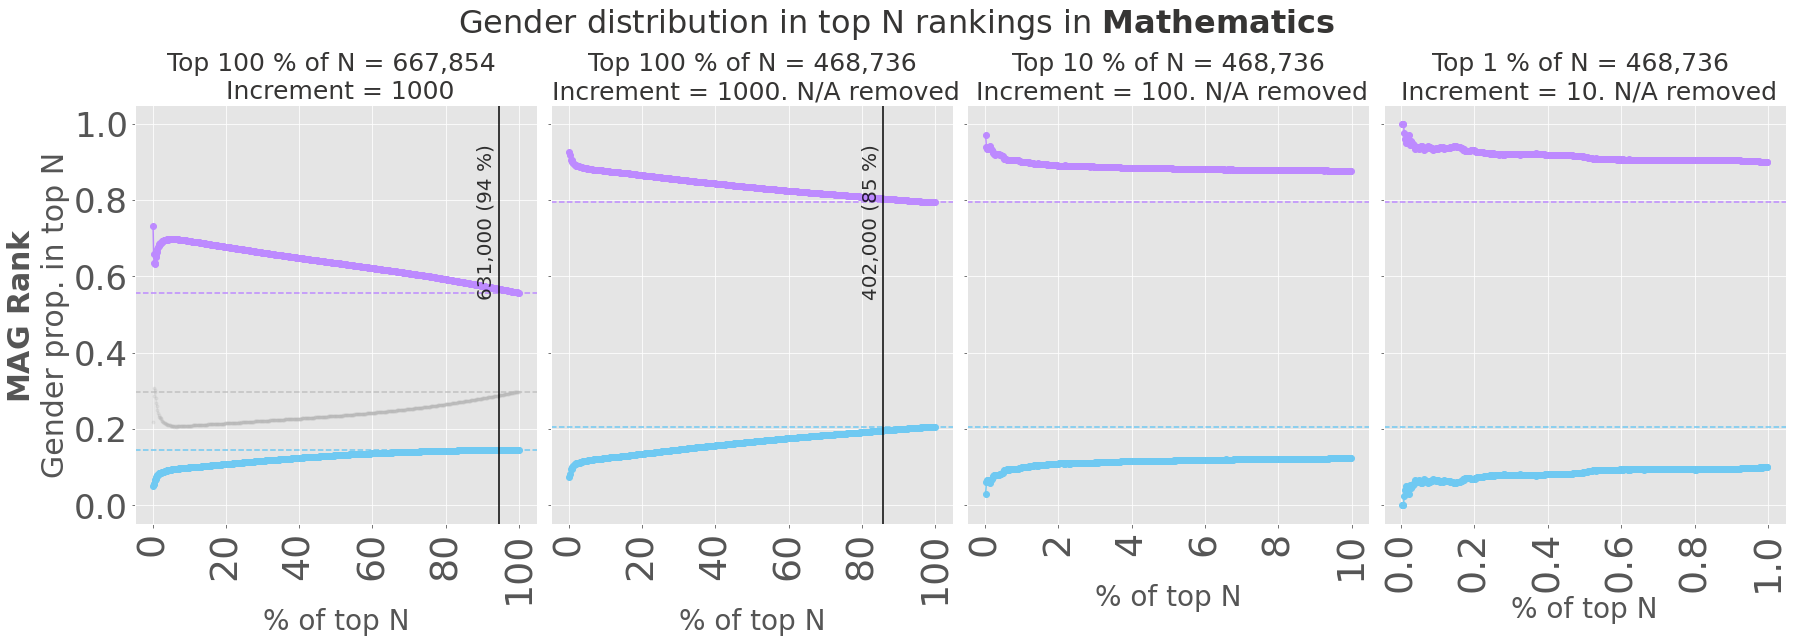

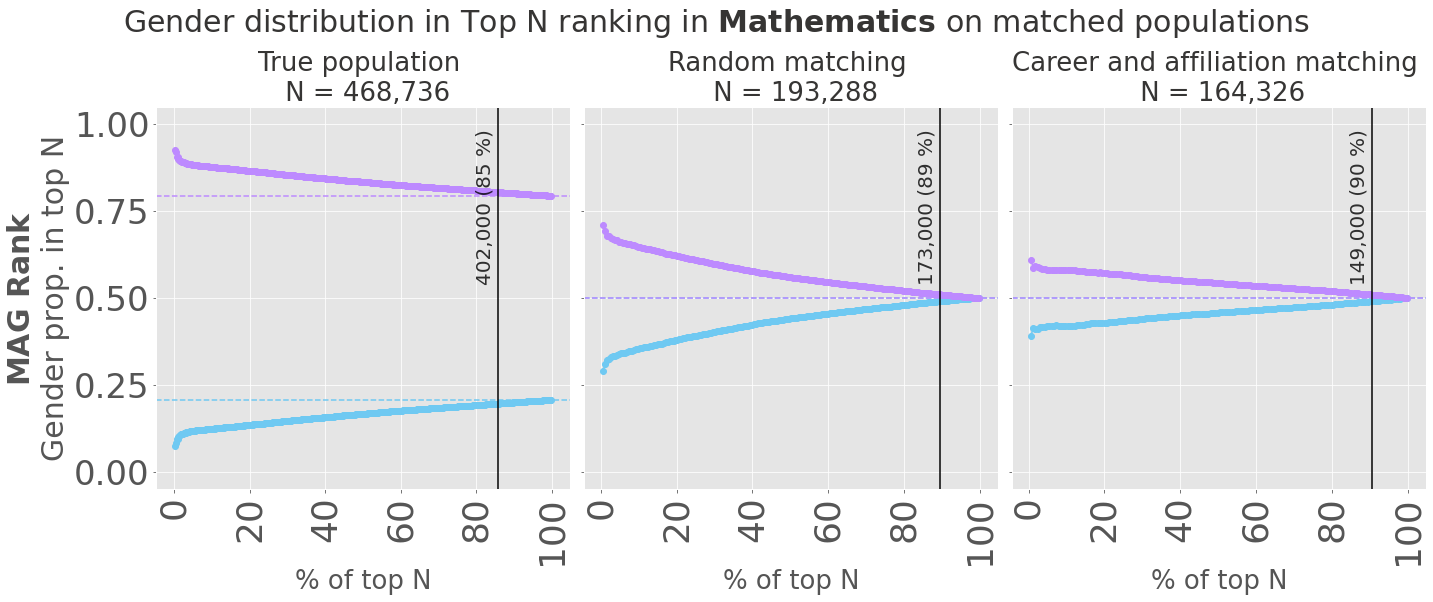

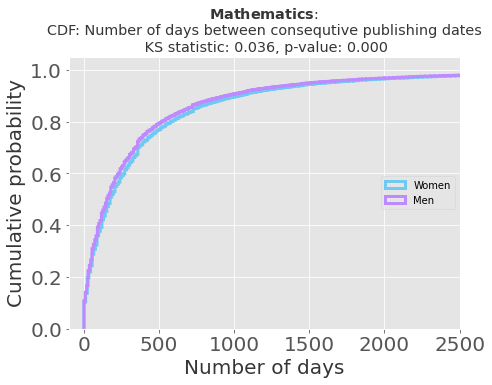

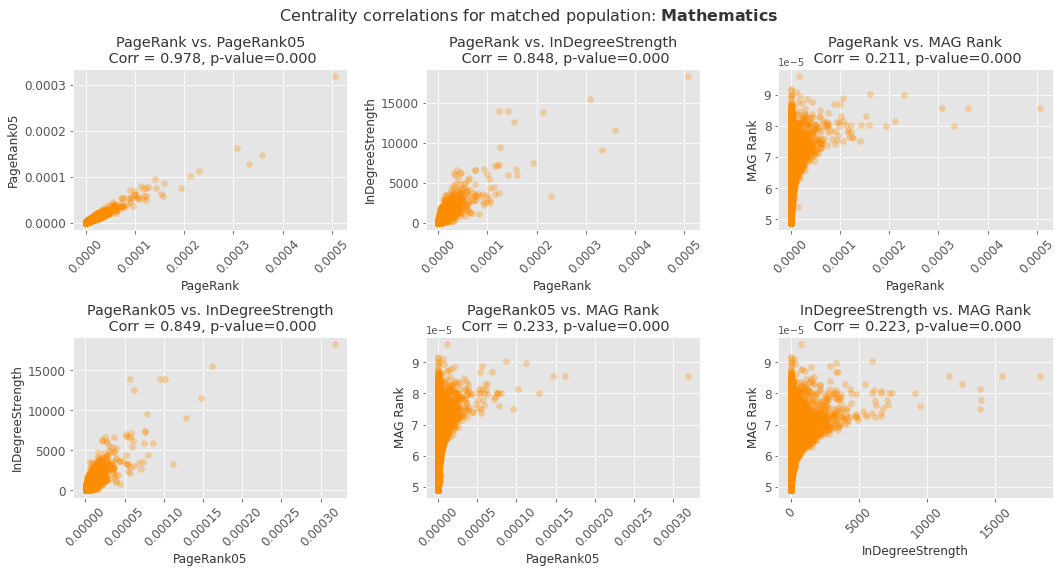

--------------------------------STARTING VIZ ON CHEMISTRY-----------------------------


gender counts before query:

1    2580695
0    1354380
Name: Gender, dtype: int64
Men with more than 1 paper:  (1486013, 12)
Women with more than 1 paper:  (754100, 12)
Number of men before removing NaN-affiliation bin: 1486013
Number of women before removing NaN-affiliation bin: 754100
Number of men after removing NaN-affiliation bin: 1121876
Number of women after removing NaN-affiliation bin: 623413


/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1157632.5
Matched data median: 1221613.5


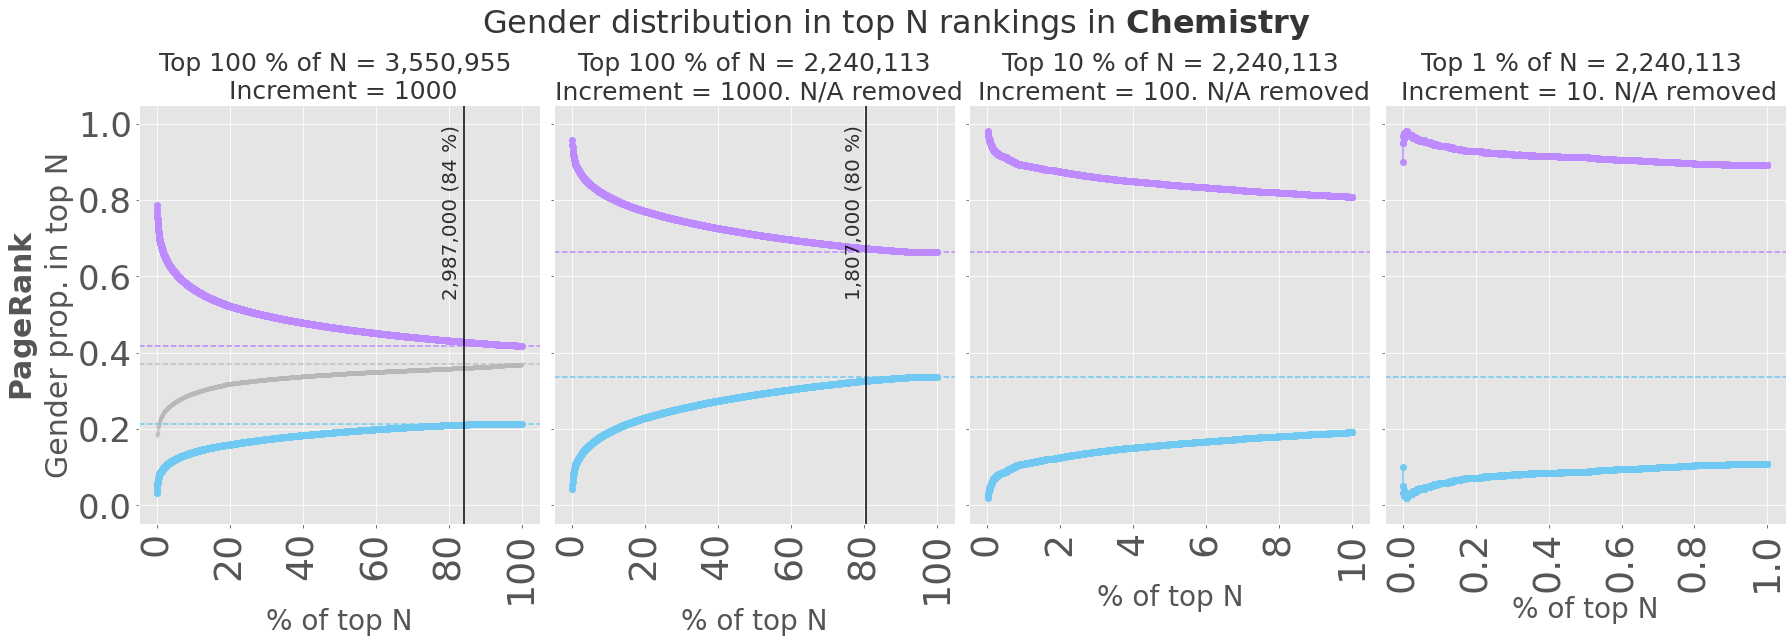

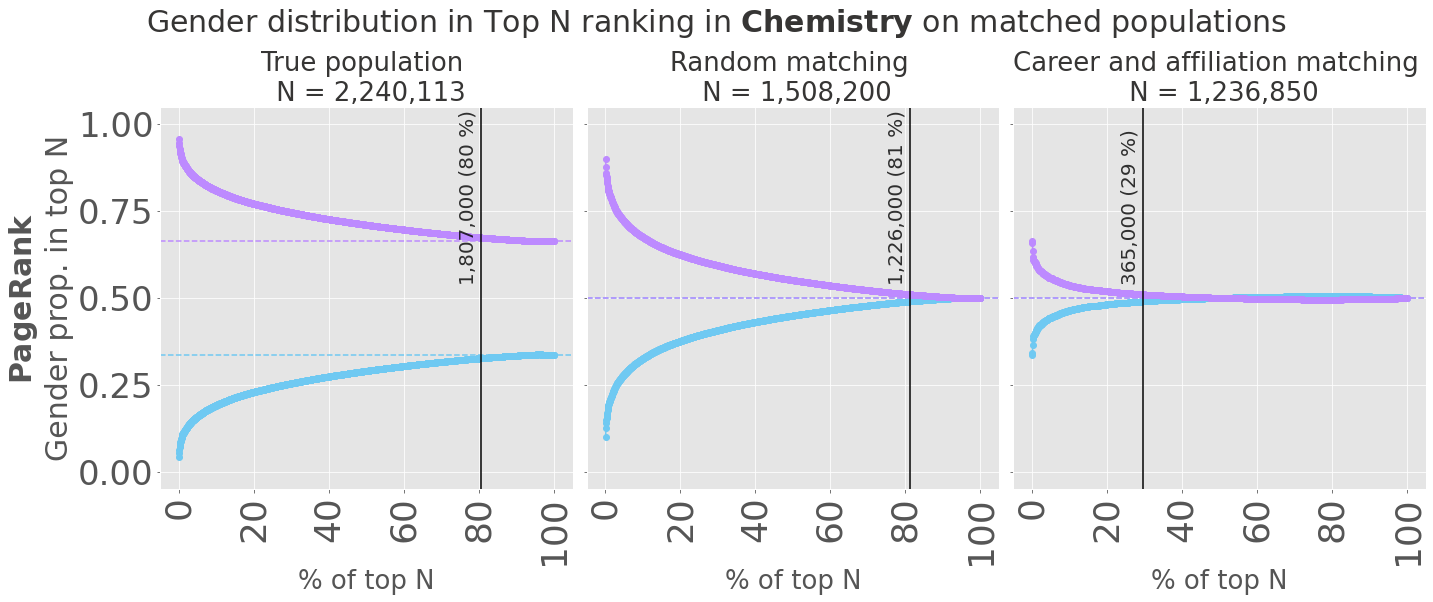

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1155082.5
Matched data median: 1208808.0


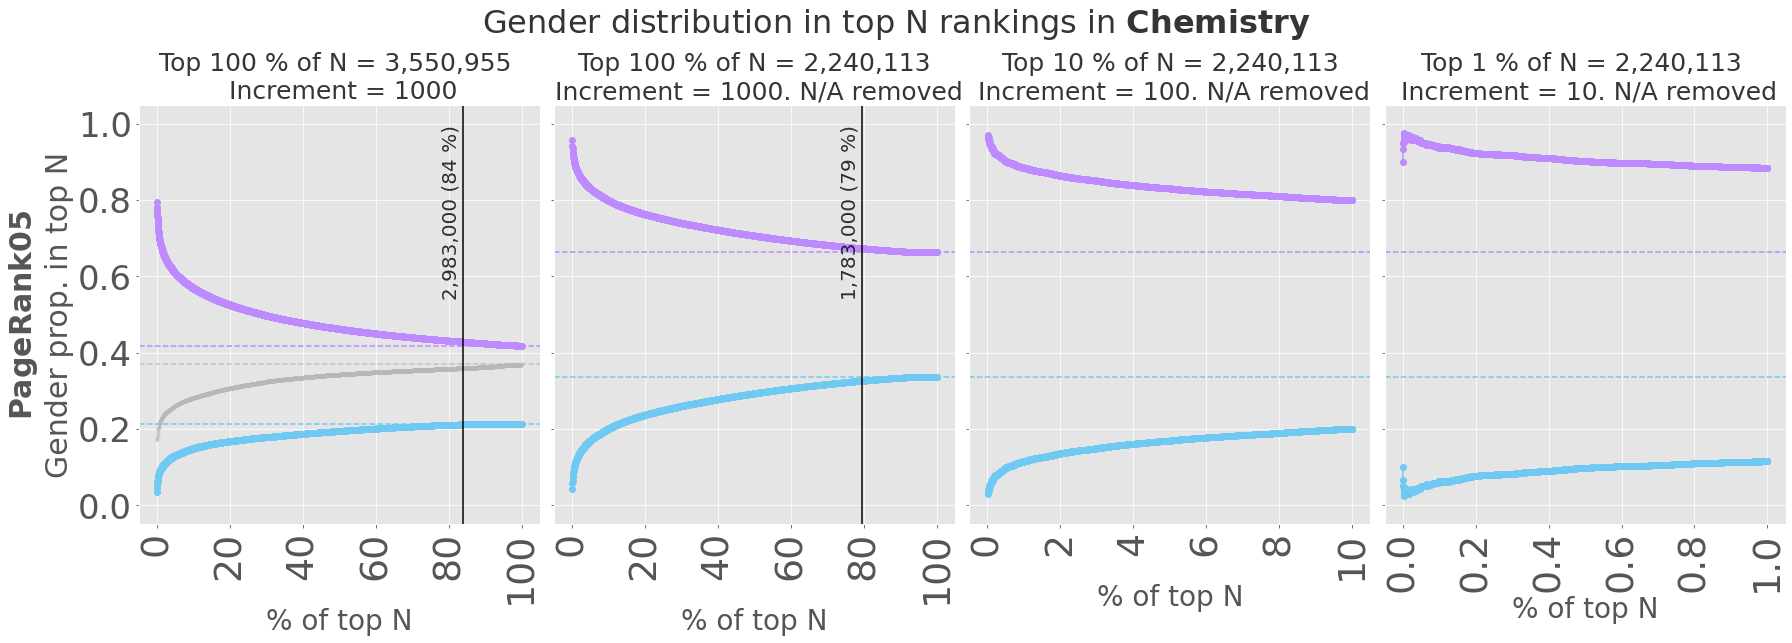

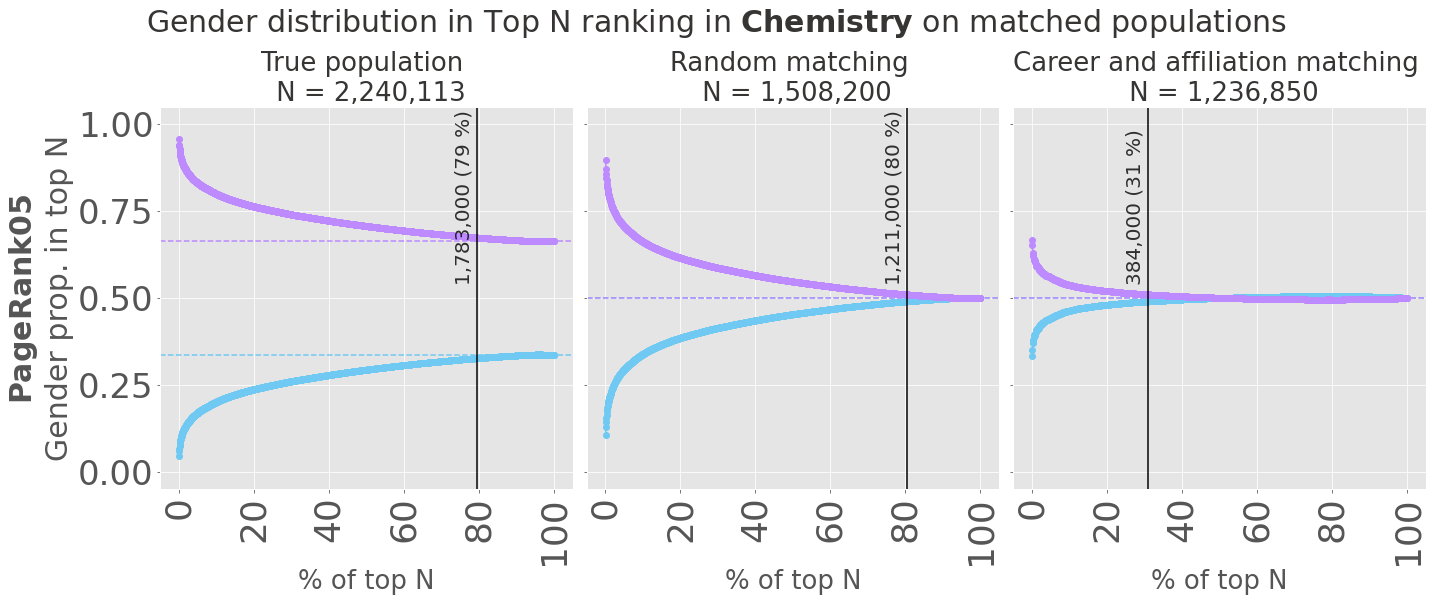

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1136860.0
Matched data median: 1122488.0


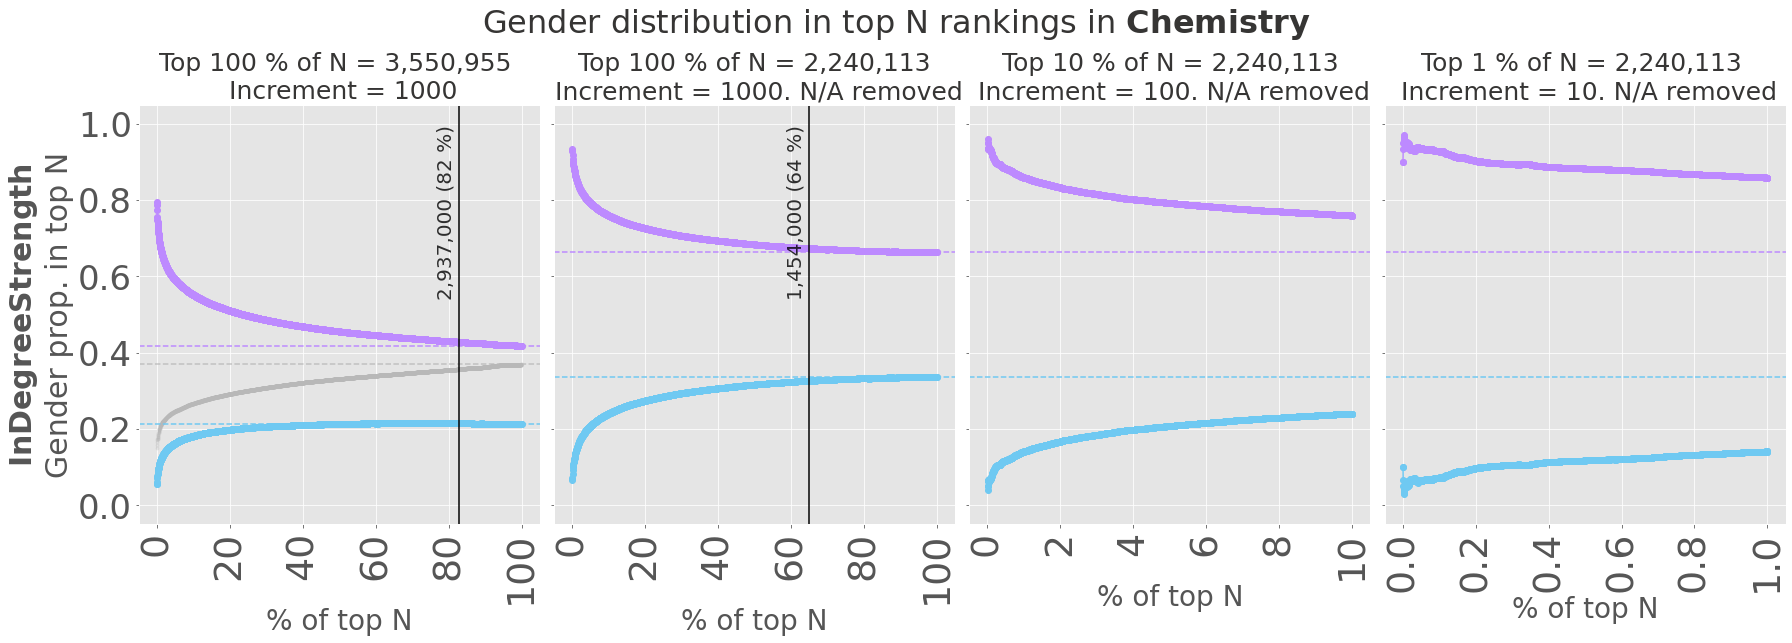

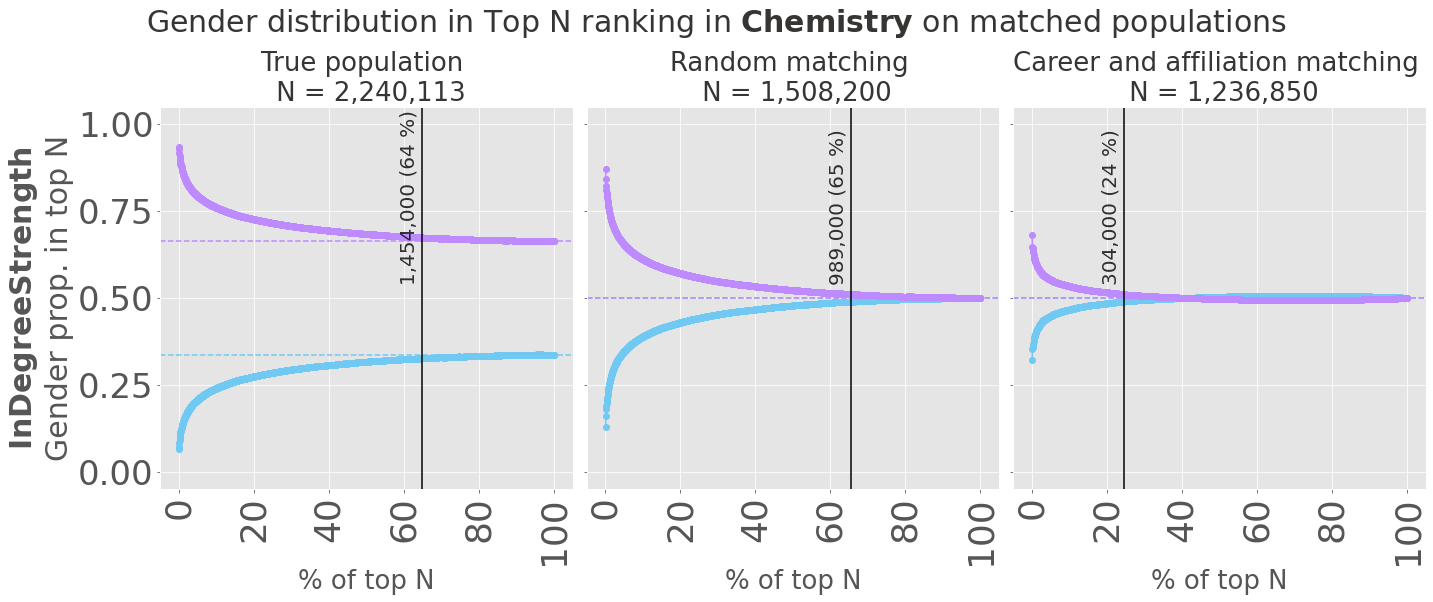

/home/laal/MAG/CentralityFairness/visualizations.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(xticks, fontsize=labelsize)
/home/laal/MAG/CentralityFairness/visualizations.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels(xticks, fontsize=labelsize)


Full data median: 1120056.0
Random data median: 1155392.5
Matched data median: 1121082.5


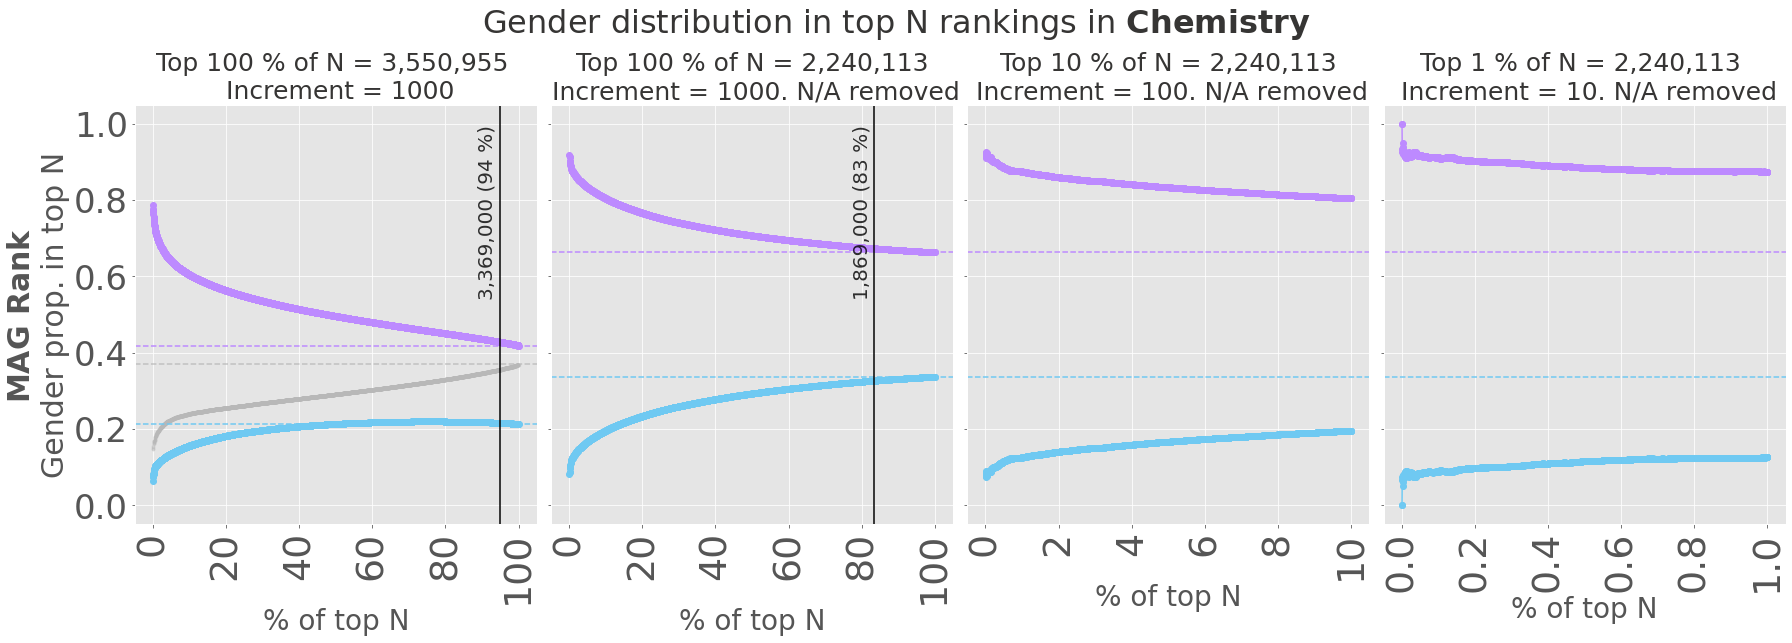

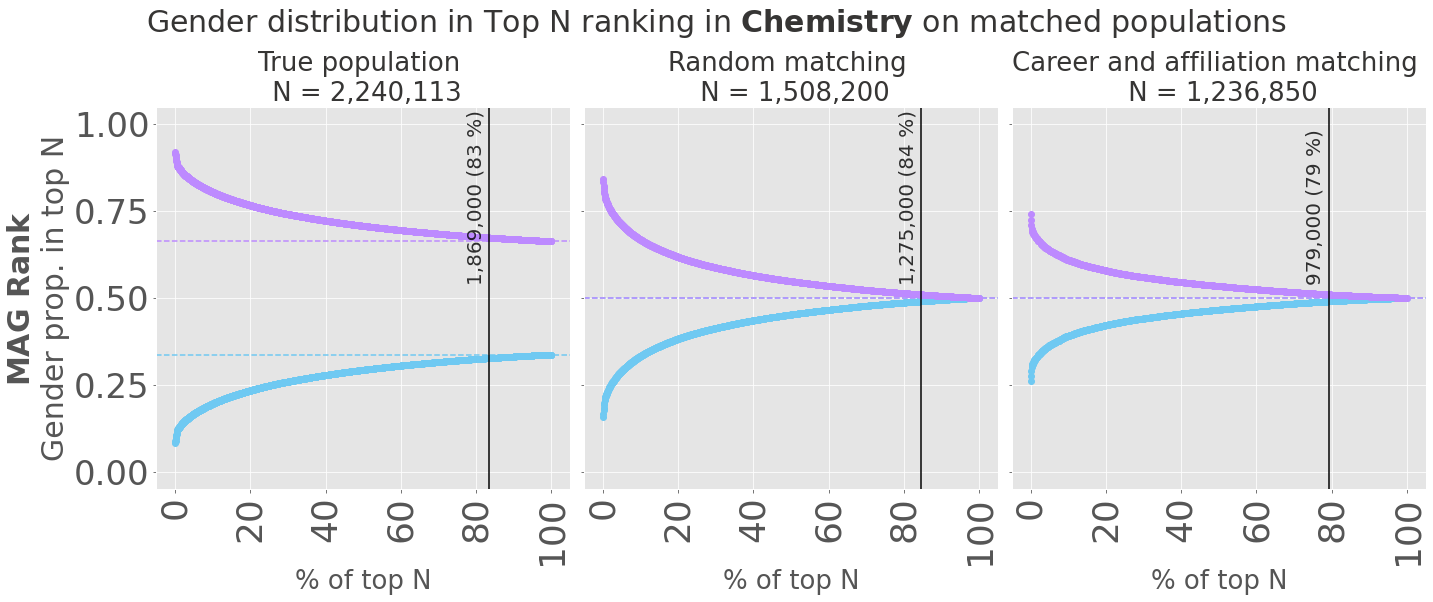

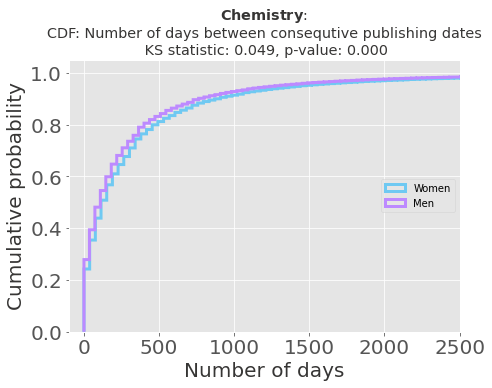

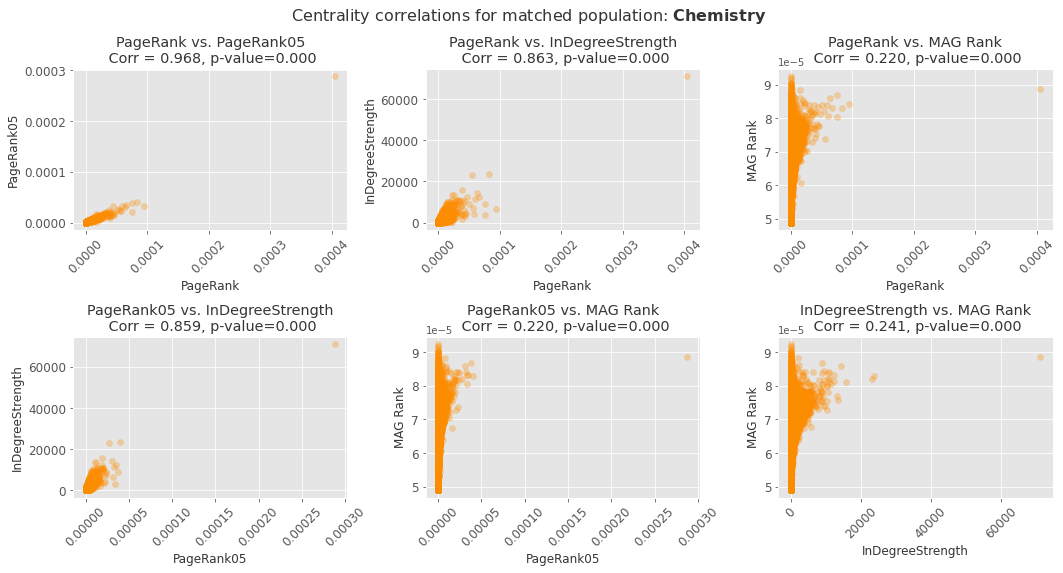

In [4]:
field_ids = {
        "Psychology": 15744967,
        "Economics": 162324750, 
        "Mathematics": 33923547,
        "Chemistry": 185592680,
    }
    
field_mapping = {
        "Economics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightEconomics2020CentralityGendered.csv", 
        "Psychology": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightPsychology2020CentralityGendered.csv",
        "Mathematics": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightMathematics2020CentralityGendered.csv",
        "Chemistry": "/home/laal/MAG/DATA/NETWORKS/SimpleWeightChemistry2020CentralityGendered.csv",
    }


for field_name, fpath in field_mapping.items():

    file_path = fpath
    field = field_name
    field_id = field_ids[field_name]
    base_filepath = "/home/laal/MAG"
    
    print("--------------------------------STARTING VIZ ON {}-----------------------------\n\n".format(field.upper()))

    destination = base_filepath + "/CentralityFairness/EVALUATIONS_OUTPUTS/matching_repeated_" + field + ".csv"

    seed = 0 if field_name != 'Chemistry' else 1
    
    data = pd.read_csv(file_path, sep="\t")
    matcher = Matcher(centrality_df = data, random_seed=seed, field=field, base_filepath=base_filepath, fos_name=field)
    matcher.load_authors(fos_id=int(field_id), folder_destination = base_filepath + "/DATA/AuthorMetadataField.csv")

    
    male_population = matcher.male_population.sample(frac=1, random_state=matcher.seed).copy()
    female_population = matcher.female_population.sample(frac=1, random_state=matcher.seed).copy()

    print("Number of men before removing NaN-affiliation bin: {}".format(male_population.shape[0]))
    print("Number of women before removing NaN-affiliation bin: {}".format(female_population.shape[0]))

    male_population = male_population[~pd.isnull(male_population.AffiliationBin)]
    female_population = female_population[~pd.isnull(female_population.AffiliationBin)]

    print("Number of men after removing NaN-affiliation bin: {}".format(male_population.shape[0]))
    print("Number of women after removing NaN-affiliation bin: {}".format(female_population.shape[0]))
    

    random_data_males, random_data_females = matcher.random_sample()
    random_data = matcher.samples_to_centrality_data(random_data_males, random_data_females)

    
    #matched_data_males, matched_data_females = matcher.matched_sample()
    #matched_data = matcher.samples_to_centrality_data(matched_data_males, matched_data_females, store=True, is_matched=True)
    
    matched_data = pd.read_csv(base_filepath +  '/CentralityFairness/MATCHING_OUTPUTS/{}_seed{}_matched.csv'.format(field_name, seed), 
                               sep="\t")
    
    
    gendered_pop = pd.concat([matcher.male_population, matcher.female_population])
    unknown_population = matcher.unknown_population

    all_authors = list(gendered_pop.AuthorId.values) + list(unknown_population.AuthorId.values)
    centrality_raw = matcher.cent_df_raw[matcher.cent_df_raw.AuthorId.isin(all_authors)]
    
    matcher.save_visualizations(field=field, centrality_df=centrality_raw, random_centrality_df=random_data, 
                                matched_centrality_df=matched_data)
    
    datediffs, ks_test = compute_ks_test(mag, matched_data, fos_id=int(field_id), base_filepath="/home/laal/MAG/DATA")
    
    plot_inter_event_cdf(datediffs, ks_test, field, 
                         filepath=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_interevent_match_visualization.png"
                         )
    
    plot_centrality_correlations(field, matched_data, 
                                 filename=base_filepath +  '/CentralityFairness/EVALUATIONS_PLOTS/' + field + "_centrality_match_visualization.png"
                                )